In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import svr_IAM
%load_ext autoreload
%autoreload 2

In [4]:
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-pastel')

### 1. Load PAGE, FUND, DICE

In [7]:
fund_data= pd.read_csv("FUND/FUND_socio_scc_complete.csv", index_col=0)
fund_data

,Year,popu,GDP_percap,emiss_total,SCC,FUND_1,FUND_2,FUND_3,FUND_4,FUND_5,FUND_6,FUND_7,FUND_8,FUND_9,FUND_10,FUND_11,FUND_12
0,1950,2.52,NaN,2283.619714,NaN,14.639145,25.608023,49.923819,64.169831,38.899969,64.682782,111.030802,125.401133,0.506948,1.555550,3.499538,4.600574
1,1951,2.57,3.713551,2335.220716,14.639145,14.931436,26.052757,50.597197,64.916795,39.494121,65.570104,112.221701,126.547405,0.535716,1.607891,3.587411,4.705183
2,1952,2.61,3.788584,2390.131278,14.931436,15.231703,26.506768,51.280143,65.672391,40.102253,66.473755,113.428704,127.707560,0.566651,1.662662,3.677951,4.812501
3,1953,2.66,3.865242,2448.707934,15.231703,15.540136,26.970239,51.972806,66.436744,40.724746,67.394107,114.652174,128.881955,0.599801,1.719910,3.771196,4.922564
4,1954,2.71,3.943565,2511.368107,15.540136,15.856960,27.443378,52.675358,67.210006,41.362016,68.331565,115.892499,130.070974,0.635238,1.779699,3.867201,5.035421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,2096,10.30,38.903338,23694.294420,91.827179,92.196046,114.236056,143.615065,147.632897,166.249136,212.304009,249.182037,223.885353,28.753640,32.108709,36.762091,38.555333
147,2097,10.30,39.462229,23916.469190,92.196046,92.566130,114.680534,144.066884,147.955173,166.923949,213.158455,249.989272,224.338819,28.913355,32.286619,36.961484,38.755983
148,2098,10.30,40.023432,24135.306090,92.566130,92.937646,115.128469,144.524867,148.283657,167.602656,214.020212,250.807310,224.801711,29.072260,32.464214,37.161299,38.957271
149,2099,10.30,40.586810,24350.667640,92.937646,93.310813,115.580099,144.989272,148.618585,168.285519,214.889558,251.636415,225.274229,29.230460,32.641605,37.361660,39.159320


In [8]:
fund_data.columns

Index(['Year', 'popu', 'GDP_percap', 'emiss_total', 'SCC', 'FUND_1', 'FUND_2',
       'FUND_3', 'FUND_4', 'FUND_5', 'FUND_6', 'FUND_7', 'FUND_8', 'FUND_9',
       'FUND_10', 'FUND_11', 'FUND_12'],
      dtype='object')

'SCC_default', 
'cs2.81_prtp1.5', 'cs3.81_prtp75_prtp1.5', 'cs11.12_prtp1.5',
'cs2.81_prtp1.03', 'cs3.81_prtp175_prtp1.03', 'cs11.12_prtp1.03',
'cs2.81_prtp3.0', 'cs3.81_prtp75_prtp3.0', 'cs11.12_prtp3.0',

In [9]:
page_data= pd.read_csv("PAGE/PAGE_socio_scc_complete.csv", index_col=0)
page_data

,Year,popu,GDP_percap,emiss_tot,SCC_base,PAGE_2.8_1.5,PAGE_3.8_1.5,PAGE_6.7_1.5,PAGE_11_1.5,PAGE_2.8_1.03,PAGE_3.8_1.03,PAGE_6.7_1.03,PAGE_11_1.03,PAGE_2.8_3,PAGE_3.8_3,PAGE_6.7_3,PAGE_11_3
0,2020,7608.085938,13.331245,42366.000,240.166992,168.094238,286.433594,816.285156,1764.890625,240.160156,412.517578,1152.175781,2383.843750,73.995117,123.368164,356.232422,863.359375
1,2021,7678.569336,13.722893,42659.375,244.125000,171.029297,291.902344,833.285156,1786.093750,244.124023,419.865234,1174.464844,2410.250000,75.840820,126.731445,367.123047,884.140625
2,2022,7748.105469,14.116795,42980.375,248.073242,173.981934,297.397461,850.140625,1808.226563,248.049805,427.152344,1196.242188,2437.015625,77.604492,129.976562,377.615234,903.703125
3,2023,7816.638672,14.512215,43331.750,252.026367,176.964844,302.924805,866.867188,1831.125000,252.018555,434.486328,1217.710938,2464.968750,79.318359,133.128906,387.810547,922.460938
4,2024,7884.105469,14.908298,43709.375,256.049805,180.015625,308.566406,883.746094,1855.179688,256.028320,441.876953,1238.972656,2494.109375,80.998047,136.230469,397.771484,940.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2096,9130.546875,55.301838,84231.625,655.243164,441.957519,783.300781,2190.761719,4221.710938,655.223633,1160.580078,3149.875000,6051.070313,153.419434,272.133789,812.746094,1589.976563
77,2097,9107.259766,56.254765,84628.375,657.447266,442.815918,784.745117,2195.664063,4219.375000,657.424805,1164.343750,3161.976563,6060.632813,152.529785,270.576172,807.960938,1573.250000
78,2098,9083.155273,57.230740,84995.750,659.575195,443.673828,786.180664,2200.593750,4216.828125,659.577148,1167.998047,3173.882813,6069.617188,151.659668,269.041016,803.189453,1556.429688
79,2099,9058.174805,58.231888,85338.000,661.699219,444.520508,787.591797,2205.457031,4214.242188,661.683594,1171.597656,3185.550781,6078.343750,150.801269,267.512695,798.503906,1539.695313


In [10]:
dice_data= pd.read_csv("DICE/DICE_socio_scc_complete.csv", index_col=0)
dice_data

,Year,popu,GDP_percap,emiss_tot,SCC,DICE_1,DICE_2,DICE_3,DICE_4,DICE_5,DICE_6,DICE_7,DICE_8,DICE_9,DICE_10,DICE_11,DICE_12
0,2020,7772.71078,15.34057,12709.68505,22.83083,21.39423,27.09137,42.59565,56.29860,30.90968,40.16681,67.03822,92.81101,10.39316,12.48534,17.51218,21.30379
1,2021,7829.18539,15.75310,12885.56488,23.71211,22.21801,28.11057,44.17957,58.41405,32.08498,41.64505,69.46393,96.19347,10.81270,12.98700,18.21233,22.17109
2,2022,7882.39656,16.17025,13057.16221,24.59977,23.04722,29.14414,45.79846,60.57594,33.26782,43.14509,71.94315,99.64880,11.23506,13.49499,18.92852,23.05874
3,2023,7932.51473,16.59202,13224.60538,25.49456,23.88261,30.19228,47.45129,62.78311,34.45943,44.66725,74.47431,103.17518,11.66055,14.00946,19.66027,23.96623
4,2024,7979.70309,17.01840,13388.02017,26.39716,24.72486,31.25520,49.13706,65.03444,35.66090,46.21180,77.05588,106.77089,12.08944,14.53056,20.40710,24.89305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2096,8693.63458,58.67660,19833.97244,117.16200,109.18131,139.90770,224.43623,298.40468,158.79220,207.14018,347.75778,479.99737,53.63841,66.24988,97.47924,121.47205
77,2097,8693.93762,59.38654,19890.74987,118.70740,110.62138,141.75243,227.32992,302.13064,160.92787,209.91598,352.27780,486.00249,54.32688,67.10545,98.72879,122.99704
78,2098,8694.17552,60.09948,19947.24819,120.25932,112.06771,143.60366,230.22930,305.85680,163.07374,212.70276,356.80845,492.00990,55.01793,67.96347,99.98005,124.52134
79,2099,8694.34120,60.81539,20003.49304,121.81766,113.52023,145.46108,233.13418,309.58275,165.22964,215.50002,361.34946,498.01900,55.71156,68.82380,101.23292,126.04475


### Pre-processing each IAM data

#### 1. FUND

In [11]:
fund_data_use= fund_data.loc[(fund_data["Year"] >= 2020) & (fund_data["Year"] <= 2100)].reset_index(drop=True)
fund_data_use

,Year,popu,GDP_percap,emiss_total,SCC,FUND_1,FUND_2,FUND_3,FUND_4,FUND_5,FUND_6,FUND_7,FUND_8,FUND_9,FUND_10,FUND_11,FUND_12
0,2020,7.55,12.956217,8738.074523,58.049110,58.570906,78.091106,111.181462,124.793377,114.071726,153.529243,202.452622,202.248470,11.847020,14.442792,18.422645,20.326307
1,2021,7.62,13.141777,8860.319873,58.570906,59.092993,78.642235,111.685036,125.191680,114.785323,154.277022,202.974466,202.458411,12.095693,14.703802,18.696368,20.602407
2,2022,7.68,13.330093,8986.940117,59.092993,59.615229,79.193010,112.187024,125.587329,115.501199,155.027958,203.500443,202.671871,12.345641,14.965913,18.970847,20.879060
3,2023,7.74,13.521263,9118.105050,59.615229,60.137469,79.743299,112.687326,125.980242,116.219158,155.781858,204.030372,202.888676,12.596772,15.229031,19.245991,21.156174
4,2024,7.80,13.715313,9253.946050,60.137469,60.659577,80.292973,113.185845,126.370340,116.939010,156.538533,204.564080,203.108660,12.848996,15.493066,19.521707,21.433660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2096,10.30,38.903338,23694.294420,91.827179,92.196046,114.236056,143.615065,147.632897,166.249136,212.304009,249.182037,223.885353,28.753640,32.108709,36.762091,38.555333
77,2097,10.30,39.462229,23916.469190,92.196046,92.566130,114.680534,144.066884,147.955173,166.923949,213.158455,249.989272,224.338819,28.913355,32.286619,36.961484,38.755983
78,2098,10.30,40.023432,24135.306090,92.566130,92.937646,115.128469,144.524867,148.283657,167.602656,214.020212,250.807310,224.801711,29.072260,32.464214,37.161299,38.957271
79,2099,10.30,40.586810,24350.667640,92.937646,93.310813,115.580099,144.989272,148.618585,168.285519,214.889558,251.636415,225.274229,29.230460,32.641605,37.361660,39.159320


In [12]:
fund_data_current= fund_data_use.copy()
fund_data_current.columns

Index(['Year', 'popu', 'GDP_percap', 'emiss_total', 'SCC', 'FUND_1', 'FUND_2',
       'FUND_3', 'FUND_4', 'FUND_5', 'FUND_6', 'FUND_7', 'FUND_8', 'FUND_9',
       'FUND_10', 'FUND_11', 'FUND_12'],
      dtype='object')

In [13]:
fund_data_current.iloc[:, -13:]= fund_data_current.iloc[:, -13:] * 1.98
fund_data_current

,Year,popu,GDP_percap,emiss_total,SCC,FUND_1,FUND_2,FUND_3,FUND_4,FUND_5,FUND_6,FUND_7,FUND_8,FUND_9,FUND_10,FUND_11,FUND_12
0,2020,7.55,12.956217,8738.074523,114.937239,115.970393,154.620389,220.139294,247.090887,225.862017,303.987902,400.856192,400.451970,23.457100,28.596728,36.476837,40.246087
1,2021,7.62,13.141777,8860.319873,115.970393,117.004127,155.711626,221.136371,247.879527,227.274940,305.468503,401.889443,400.867654,23.949472,29.113528,37.018808,40.792766
2,2022,7.68,13.330093,8986.940117,117.004127,118.038153,156.802161,222.130308,248.662912,228.692373,306.955356,402.930876,401.290304,24.444368,29.632508,37.562278,41.340539
3,2023,7.74,13.521263,9118.105050,118.038153,119.072189,157.891732,223.120906,249.440879,230.113932,308.448079,403.980137,401.719579,24.941608,30.153482,38.107062,41.889225
4,2024,7.80,13.715313,9253.946050,119.072189,120.105963,158.980086,224.107972,250.213274,231.539240,309.946296,405.036879,402.155146,25.441012,30.676270,38.652979,42.438646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2096,10.30,38.903338,23694.294420,181.817815,182.548171,226.187391,284.357829,292.313136,329.173289,420.361937,493.380433,443.292999,56.932207,63.575244,72.788941,76.339559
77,2097,10.30,39.462229,23916.469190,182.548171,183.280937,227.067458,285.252431,292.951243,330.509419,422.053741,494.978759,444.190862,57.248444,63.927506,73.183738,76.736847
78,2098,10.30,40.023432,24135.306090,183.280937,184.016539,227.954368,286.159238,293.601641,331.853260,423.760019,496.598474,445.107387,57.563075,64.279143,73.579372,77.135397
79,2099,10.30,40.586810,24350.667640,184.016539,184.755409,228.848596,287.078759,294.264799,333.205328,425.481326,498.240101,446.042974,57.876311,64.630378,73.976086,77.535453


#### 2. PAGE

In [14]:
page_data_current= page_data.copy()

page_data_current.iloc[:, -13:]= page_data_current.iloc[:, -13:] * 1.27
page_data_current


,Year,popu,GDP_percap,emiss_tot,SCC_base,PAGE_2.8_1.5,PAGE_3.8_1.5,PAGE_6.7_1.5,PAGE_11_1.5,PAGE_2.8_1.03,PAGE_3.8_1.03,PAGE_6.7_1.03,PAGE_11_1.03,PAGE_2.8_3,PAGE_3.8_3,PAGE_6.7_3,PAGE_11_3
0,2020,7608.085938,13.331245,42366.000,305.012080,213.479683,363.770664,1036.682149,2241.411094,305.003399,523.897324,1463.263242,3027.481563,93.973799,156.677568,452.415176,1096.466406
1,2021,7678.569336,13.722893,42659.375,310.038750,217.207207,370.715977,1058.272149,2268.339063,310.037510,533.228848,1491.570352,3061.017500,96.317842,160.948936,466.246270,1122.858594
2,2022,7748.105469,14.116795,42980.375,315.053018,220.957056,377.694775,1079.678594,2296.447735,315.023252,542.483477,1519.227579,3095.009844,98.557705,165.070234,479.571348,1147.702969
3,2023,7816.638672,14.512215,43331.750,320.073486,224.745352,384.714502,1100.921328,2325.528750,320.063564,551.797637,1546.492891,3130.510313,100.734316,169.073711,492.519395,1171.525391
4,2024,7884.105469,14.908298,43709.375,325.183252,228.619844,391.879336,1122.357539,2356.078204,325.155967,561.183730,1573.495273,3167.518906,102.867520,173.012695,505.169785,1194.474688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2096,9130.546875,55.301838,84231.625,832.158818,561.286050,994.791992,2782.267383,5361.572891,832.134014,1473.936699,4000.341250,7684.859298,194.842681,345.609912,1032.187539,2019.270235
77,2097,9107.259766,56.254765,84628.375,834.958027,562.376216,996.626299,2788.493360,5358.606250,834.929502,1478.716563,4015.710235,7697.003673,193.712827,343.631738,1026.110391,1998.027500
78,2098,9083.155273,57.230740,84995.750,837.660498,563.465762,998.449443,2794.754063,5355.371719,837.662978,1483.357520,4030.831173,7708.413829,192.607778,341.682090,1020.050605,1976.665704
79,2099,9058.174805,58.231888,85338.000,840.358008,564.541045,1000.241582,2800.930429,5352.087579,840.338164,1487.929023,4045.649492,7719.496563,191.517612,339.741123,1014.099961,1955.413048


In [15]:
page_data_current["popu"]= page_data_current["popu"]/1000

In [16]:
page_data_current

,Year,popu,GDP_percap,emiss_tot,SCC_base,PAGE_2.8_1.5,PAGE_3.8_1.5,PAGE_6.7_1.5,PAGE_11_1.5,PAGE_2.8_1.03,PAGE_3.8_1.03,PAGE_6.7_1.03,PAGE_11_1.03,PAGE_2.8_3,PAGE_3.8_3,PAGE_6.7_3,PAGE_11_3
0,2020,7.608086,13.331245,42366.000,305.012080,213.479683,363.770664,1036.682149,2241.411094,305.003399,523.897324,1463.263242,3027.481563,93.973799,156.677568,452.415176,1096.466406
1,2021,7.678569,13.722893,42659.375,310.038750,217.207207,370.715977,1058.272149,2268.339063,310.037510,533.228848,1491.570352,3061.017500,96.317842,160.948936,466.246270,1122.858594
2,2022,7.748105,14.116795,42980.375,315.053018,220.957056,377.694775,1079.678594,2296.447735,315.023252,542.483477,1519.227579,3095.009844,98.557705,165.070234,479.571348,1147.702969
3,2023,7.816639,14.512215,43331.750,320.073486,224.745352,384.714502,1100.921328,2325.528750,320.063564,551.797637,1546.492891,3130.510313,100.734316,169.073711,492.519395,1171.525391
4,2024,7.884105,14.908298,43709.375,325.183252,228.619844,391.879336,1122.357539,2356.078204,325.155967,561.183730,1573.495273,3167.518906,102.867520,173.012695,505.169785,1194.474688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2096,9.130547,55.301838,84231.625,832.158818,561.286050,994.791992,2782.267383,5361.572891,832.134014,1473.936699,4000.341250,7684.859298,194.842681,345.609912,1032.187539,2019.270235
77,2097,9.107260,56.254765,84628.375,834.958027,562.376216,996.626299,2788.493360,5358.606250,834.929502,1478.716563,4015.710235,7697.003673,193.712827,343.631738,1026.110391,1998.027500
78,2098,9.083155,57.230740,84995.750,837.660498,563.465762,998.449443,2794.754063,5355.371719,837.662978,1483.357520,4030.831173,7708.413829,192.607778,341.682090,1020.050605,1976.665704
79,2099,9.058175,58.231888,85338.000,840.358008,564.541045,1000.241582,2800.930429,5352.087579,840.338164,1487.929023,4045.649492,7719.496563,191.517612,339.741123,1014.099961,1955.413048


In [17]:
fund_data_current.columns

Index(['Year', 'popu', 'GDP_percap', 'emiss_total', 'SCC', 'FUND_1', 'FUND_2',
       'FUND_3', 'FUND_4', 'FUND_5', 'FUND_6', 'FUND_7', 'FUND_8', 'FUND_9',
       'FUND_10', 'FUND_11', 'FUND_12'],
      dtype='object')

In [18]:
page_data_current.columns = ['Year', 'popu', 'GDP_percap', 'emiss_total', 'SCC', 'PAGE_1', 'PAGE_2', 'PAGE_3', 'PAGE_4', 
                                                                                 'PAGE_5', 'PAGE_6', 'PAGE_7', 'PAGE_8', 'PAGE_9',
                                                                                 'PAGE_10', 'PAGE_11', 'PAGE_12']

In [19]:
page_data_current

,Year,popu,GDP_percap,emiss_total,SCC,PAGE_1,PAGE_2,PAGE_3,PAGE_4,PAGE_5,PAGE_6,PAGE_7,PAGE_8,PAGE_9,PAGE_10,PAGE_11,PAGE_12
0,2020,7.608086,13.331245,42366.000,305.012080,213.479683,363.770664,1036.682149,2241.411094,305.003399,523.897324,1463.263242,3027.481563,93.973799,156.677568,452.415176,1096.466406
1,2021,7.678569,13.722893,42659.375,310.038750,217.207207,370.715977,1058.272149,2268.339063,310.037510,533.228848,1491.570352,3061.017500,96.317842,160.948936,466.246270,1122.858594
2,2022,7.748105,14.116795,42980.375,315.053018,220.957056,377.694775,1079.678594,2296.447735,315.023252,542.483477,1519.227579,3095.009844,98.557705,165.070234,479.571348,1147.702969
3,2023,7.816639,14.512215,43331.750,320.073486,224.745352,384.714502,1100.921328,2325.528750,320.063564,551.797637,1546.492891,3130.510313,100.734316,169.073711,492.519395,1171.525391
4,2024,7.884105,14.908298,43709.375,325.183252,228.619844,391.879336,1122.357539,2356.078204,325.155967,561.183730,1573.495273,3167.518906,102.867520,173.012695,505.169785,1194.474688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2096,9.130547,55.301838,84231.625,832.158818,561.286050,994.791992,2782.267383,5361.572891,832.134014,1473.936699,4000.341250,7684.859298,194.842681,345.609912,1032.187539,2019.270235
77,2097,9.107260,56.254765,84628.375,834.958027,562.376216,996.626299,2788.493360,5358.606250,834.929502,1478.716563,4015.710235,7697.003673,193.712827,343.631738,1026.110391,1998.027500
78,2098,9.083155,57.230740,84995.750,837.660498,563.465762,998.449443,2794.754063,5355.371719,837.662978,1483.357520,4030.831173,7708.413829,192.607778,341.682090,1020.050605,1976.665704
79,2099,9.058175,58.231888,85338.000,840.358008,564.541045,1000.241582,2800.930429,5352.087579,840.338164,1487.929023,4045.649492,7719.496563,191.517612,339.741123,1014.099961,1955.413048


#### 3. DICE

In [20]:
dice_data_current= dice_data.copy()

dice_data_current.iloc[:, -13:]= dice_data_current.iloc[:, -13:] * 1.5
dice_data_current


,Year,popu,GDP_percap,emiss_tot,SCC,DICE_1,DICE_2,DICE_3,DICE_4,DICE_5,DICE_6,DICE_7,DICE_8,DICE_9,DICE_10,DICE_11,DICE_12
0,2020,7772.71078,15.34057,12709.68505,34.246245,32.091345,40.637055,63.893475,84.447900,46.364520,60.250215,100.557330,139.216515,15.589740,18.728010,26.268270,31.955685
1,2021,7829.18539,15.75310,12885.56488,35.568165,33.327015,42.165855,66.269355,87.621075,48.127470,62.467575,104.195895,144.290205,16.219050,19.480500,27.318495,33.256635
2,2022,7882.39656,16.17025,13057.16221,36.899655,34.570830,43.716210,68.697690,90.863910,49.901730,64.717635,107.914725,149.473200,16.852590,20.242485,28.392780,34.588110
3,2023,7932.51473,16.59202,13224.60538,38.241840,35.823915,45.288420,71.176935,94.174665,51.689145,67.000875,111.711465,154.762770,17.490825,21.014190,29.490405,35.949345
4,2024,7979.70309,17.01840,13388.02017,39.595740,37.087290,46.882800,73.705590,97.551660,53.491350,69.317700,115.583820,160.156335,18.134160,21.795840,30.610650,37.339575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2096,8693.63458,58.67660,19833.97244,175.743000,163.771965,209.861550,336.654345,447.607020,238.188300,310.710270,521.636670,719.996055,80.457615,99.374820,146.218860,182.208075
77,2097,8693.93762,59.38654,19890.74987,178.061100,165.932070,212.628645,340.994880,453.195960,241.391805,314.873970,528.416700,729.003735,81.490320,100.658175,148.093185,184.495560
78,2098,8694.17552,60.09948,19947.24819,180.388980,168.101565,215.405490,345.343950,458.785200,244.610610,319.054140,535.212675,738.014850,82.526895,101.945205,149.970075,186.782010
79,2099,8694.34120,60.81539,20003.49304,182.726490,170.280345,218.191620,349.701270,464.374125,247.844460,323.250030,542.024190,747.028500,83.567340,103.235700,151.849380,189.067125


In [39]:
dice_data_current.rename(columns={"emiss_tot": "emiss_total"}, inplace=True)

In [29]:
dice_data_current["popu"]= dice_data_current["popu"]/1000

In [40]:
dice_data_current

,Year,popu,GDP_percap,emiss_total,SCC,DICE_1,DICE_2,DICE_3,DICE_4,DICE_5,DICE_6,DICE_7,DICE_8,DICE_9,DICE_10,DICE_11,DICE_12
0,2020,7.772711,15.34057,12709.68505,34.246245,32.091345,40.637055,63.893475,84.447900,46.364520,60.250215,100.557330,139.216515,15.589740,18.728010,26.268270,31.955685
1,2021,7.829185,15.75310,12885.56488,35.568165,33.327015,42.165855,66.269355,87.621075,48.127470,62.467575,104.195895,144.290205,16.219050,19.480500,27.318495,33.256635
2,2022,7.882397,16.17025,13057.16221,36.899655,34.570830,43.716210,68.697690,90.863910,49.901730,64.717635,107.914725,149.473200,16.852590,20.242485,28.392780,34.588110
3,2023,7.932515,16.59202,13224.60538,38.241840,35.823915,45.288420,71.176935,94.174665,51.689145,67.000875,111.711465,154.762770,17.490825,21.014190,29.490405,35.949345
4,2024,7.979703,17.01840,13388.02017,39.595740,37.087290,46.882800,73.705590,97.551660,53.491350,69.317700,115.583820,160.156335,18.134160,21.795840,30.610650,37.339575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2096,8.693635,58.67660,19833.97244,175.743000,163.771965,209.861550,336.654345,447.607020,238.188300,310.710270,521.636670,719.996055,80.457615,99.374820,146.218860,182.208075
77,2097,8.693938,59.38654,19890.74987,178.061100,165.932070,212.628645,340.994880,453.195960,241.391805,314.873970,528.416700,729.003735,81.490320,100.658175,148.093185,184.495560
78,2098,8.694176,60.09948,19947.24819,180.388980,168.101565,215.405490,345.343950,458.785200,244.610610,319.054140,535.212675,738.014850,82.526895,101.945205,149.970075,186.782010
79,2099,8.694341,60.81539,20003.49304,182.726490,170.280345,218.191620,349.701270,464.374125,247.844460,323.250030,542.024190,747.028500,83.567340,103.235700,151.849380,189.067125


### 2. Make X and y dataset

In [41]:
PAGE_X_df= page_data_current.iloc[:, :4]
PAGE_y_df= page_data_current.iloc[:, -13:]

FUND_X_df= fund_data_current.iloc[:, :4]
FUND_y_df= fund_data_current.iloc[:, -13:]

DICE_X_df= dice_data_current.iloc[:, :4]
DICE_y_df= dice_data_current.iloc[:, -13:]


In [42]:
PAGE_X_df.columns, PAGE_y_df.columns

(Index(['Year', 'popu', 'GDP_percap', 'emiss_total'], dtype='object'),
 Index(['SCC', 'PAGE_1', 'PAGE_2', 'PAGE_3', 'PAGE_4', 'PAGE_5', 'PAGE_6',
        'PAGE_7', 'PAGE_8', 'PAGE_9', 'PAGE_10', 'PAGE_11', 'PAGE_12'],
       dtype='object'))

In [43]:
FUND_X_df.columns, FUND_y_df.columns

(Index(['Year', 'popu', 'GDP_percap', 'emiss_total'], dtype='object'),
 Index(['SCC', 'FUND_1', 'FUND_2', 'FUND_3', 'FUND_4', 'FUND_5', 'FUND_6',
        'FUND_7', 'FUND_8', 'FUND_9', 'FUND_10', 'FUND_11', 'FUND_12'],
       dtype='object'))

In [44]:
DICE_X_df.columns, DICE_y_df.columns

(Index(['Year', 'popu', 'GDP_percap', 'emiss_total'], dtype='object'),
 Index(['SCC', 'DICE_1', 'DICE_2', 'DICE_3', 'DICE_4', 'DICE_5', 'DICE_6',
        'DICE_7', 'DICE_8', 'DICE_9', 'DICE_10', 'DICE_11', 'DICE_12'],
       dtype='object'))

In [45]:
PAGE_y_df.columns= ['SCC', 'SCC_1', 'SCC_2', 'SCC_3', 'SCC_4', 'SCC_5', 'SCC_6', 
                            'SCC_7', 'SCC_8', 'SCC_9', 'SCC_10', 'SCC_11', 'SCC_12']

FUND_y_df.columns= ['SCC', 'SCC_1', 'SCC_2', 'SCC_3', 'SCC_4', 'SCC_5', 'SCC_6', 
                            'SCC_7', 'SCC_8', 'SCC_9', 'SCC_10', 'SCC_11', 'SCC_12']

DICE_y_df.columns= ['SCC', 'SCC_1', 'SCC_2', 'SCC_3', 'SCC_4', 'SCC_5', 'SCC_6', 
                            'SCC_7', 'SCC_8', 'SCC_9', 'SCC_10', 'SCC_11', 'SCC_12']

In [46]:
# PAGE_y_df, 
FUND_y_df

,SCC,SCC_1,SCC_2,SCC_3,SCC_4,SCC_5,SCC_6,SCC_7,SCC_8,SCC_9,SCC_10,SCC_11,SCC_12
0,114.937239,115.970393,154.620389,220.139294,247.090887,225.862017,303.987902,400.856192,400.451970,23.457100,28.596728,36.476837,40.246087
1,115.970393,117.004127,155.711626,221.136371,247.879527,227.274940,305.468503,401.889443,400.867654,23.949472,29.113528,37.018808,40.792766
2,117.004127,118.038153,156.802161,222.130308,248.662912,228.692373,306.955356,402.930876,401.290304,24.444368,29.632508,37.562278,41.340539
3,118.038153,119.072189,157.891732,223.120906,249.440879,230.113932,308.448079,403.980137,401.719579,24.941608,30.153482,38.107062,41.889225
4,119.072189,120.105963,158.980086,224.107972,250.213274,231.539240,309.946296,405.036879,402.155146,25.441012,30.676270,38.652979,42.438646
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,181.817815,182.548171,226.187391,284.357829,292.313136,329.173289,420.361937,493.380433,443.292999,56.932207,63.575244,72.788941,76.339559
77,182.548171,183.280937,227.067458,285.252431,292.951243,330.509419,422.053741,494.978759,444.190862,57.248444,63.927506,73.183738,76.736847
78,183.280937,184.016539,227.954368,286.159238,293.601641,331.853260,423.760019,496.598474,445.107387,57.563075,64.279143,73.579372,77.135397
79,184.016539,184.755409,228.848596,287.078759,294.264799,333.205328,425.481326,498.240101,446.042974,57.876311,64.630378,73.976086,77.535453


In [47]:
FUND_y_df.columns

Index(['SCC', 'SCC_1', 'SCC_2', 'SCC_3', 'SCC_4', 'SCC_5', 'SCC_6', 'SCC_7',
       'SCC_8', 'SCC_9', 'SCC_10', 'SCC_11', 'SCC_12'],
      dtype='object')

In [48]:
X_df= pd.concat([FUND_X_df, PAGE_X_df, DICE_X_df]).reset_index(drop=True)
X_df

,Year,popu,GDP_percap,emiss_total
0,2020,7.550000,12.956217,8738.074523
1,2021,7.620000,13.141777,8860.319873
2,2022,7.680000,13.330093,8986.940117
3,2023,7.740000,13.521263,9118.105050
4,2024,7.800000,13.715313,9253.946050
...,...,...,...,...
238,2096,8.693635,58.676600,19833.972440
239,2097,8.693938,59.386540,19890.749870
240,2098,8.694176,60.099480,19947.248190
241,2099,8.694341,60.815390,20003.493040


In [49]:
y_df= pd.concat([FUND_y_df, PAGE_y_df, DICE_y_df]).reset_index(drop=True)
y_df

,SCC,SCC_1,SCC_2,SCC_3,SCC_4,SCC_5,SCC_6,SCC_7,SCC_8,SCC_9,SCC_10,SCC_11,SCC_12
0,114.937239,115.970393,154.620389,220.139294,247.090887,225.862017,303.987902,400.856192,400.451970,23.457100,28.596728,36.476837,40.246087
1,115.970393,117.004127,155.711626,221.136371,247.879527,227.274940,305.468503,401.889443,400.867654,23.949472,29.113528,37.018808,40.792766
2,117.004127,118.038153,156.802161,222.130308,248.662912,228.692373,306.955356,402.930876,401.290304,24.444368,29.632508,37.562278,41.340539
3,118.038153,119.072189,157.891732,223.120906,249.440879,230.113932,308.448079,403.980137,401.719579,24.941608,30.153482,38.107062,41.889225
4,119.072189,120.105963,158.980086,224.107972,250.213274,231.539240,309.946296,405.036879,402.155146,25.441012,30.676270,38.652979,42.438646
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,175.743000,163.771965,209.861550,336.654345,447.607020,238.188300,310.710270,521.636670,719.996055,80.457615,99.374820,146.218860,182.208075
239,178.061100,165.932070,212.628645,340.994880,453.195960,241.391805,314.873970,528.416700,729.003735,81.490320,100.658175,148.093185,184.495560
240,180.388980,168.101565,215.405490,345.343950,458.785200,244.610610,319.054140,535.212675,738.014850,82.526895,101.945205,149.970075,186.782010
241,182.726490,170.280345,218.191620,349.701270,464.374125,247.844460,323.250030,542.024190,747.028500,83.567340,103.235700,151.849380,189.067125


In [50]:
y_df_prtp15= y_df[['SCC_1', 'SCC_2', 'SCC_3', 'SCC_4']]
y_df_prtp1= y_df[['SCC_5', 'SCC_6', 'SCC_7', 'SCC_8']]
y_df_prtp3= y_df[['SCC_9', 'SCC_10', 'SCC_11', 'SCC_12']]

### 3. Scaling

In [329]:
# prtp_name= "prtp_15"
# y_df_use= y_df_prtp15.copy()

# prtp_name= "prtp_1"
# y_df_use= y_df_prtp1.copy()

prtp_name= "prtp_3"
y_df_use= y_df_prtp3.copy()


In [330]:
len(y_df_prtp1), len(y_df_prtp15)

(243, 243)

In [331]:
svr_prtp_folder= "SVR_01_1030_" + prtp_name

svr_IAM.making_dir(dir_name= svr_prtp_folder)

Directory  SVR_01_1030_prtp_3  Created 


In [332]:
X_df.iloc[:, 1:]

,popu,GDP_percap,emiss_total
0,7.550000,12.956217,8738.074523
1,7.620000,13.141777,8860.319873
2,7.680000,13.330093,8986.940117
3,7.740000,13.521263,9118.105050
4,7.800000,13.715313,9253.946050
...,...,...,...
238,8.693635,58.676600,19833.972440
239,8.693938,59.386540,19890.749870
240,8.694176,60.099480,19947.248190
241,8.694341,60.815390,20003.493040


In [333]:
scaler= 'minmax'

X_scld= svr_IAM.scaling_transform(choose_scaler= scaler, for_scale= X_df.iloc[:, 1:])
y_scld= svr_IAM.scaling_transform(choose_scaler= scaler, for_scale= y_df_use)

In [334]:
X_scld, X_scld.shape

(array([[0.        , 0.        , 0.        ],
        [0.02545455, 0.00381983, 0.00158913],
        [0.04727273, 0.0076964 , 0.00323513],
        [0.06909091, 0.01163171, 0.00494021],
        [0.09090909, 0.01562632, 0.00670608],
        [0.11272727, 0.01968229, 0.00846325],
        [0.13454545, 0.02380022, 0.01023981],
        [0.15636364, 0.02797708, 0.012037  ],
        [0.17454545, 0.03221342, 0.01385346],
        [0.19272727, 0.03651017, 0.0156896 ],
        [0.21454545, 0.04086867, 0.01753083],
        [0.23272727, 0.04529064, 0.0193954 ],
        [0.24727273, 0.04975178, 0.02128308],
        [0.26545455, 0.05425199, 0.02319316],
        [0.28363636, 0.05879136, 0.02512714],
        [0.30181818, 0.06337063, 0.02708431],
        [0.32      , 0.06799073, 0.029064  ],
        [0.33818182, 0.07265214, 0.03106726],
        [0.35636364, 0.07735489, 0.0330932 ],
        [0.37454545, 0.08209911, 0.03514318],
        [0.39272727, 0.08688575, 0.03721595],
        [0.41090909, 0.09171582, 0

In [335]:
y_scld, y_scld.shape

(array([[4.07215850e-02, 2.81172379e-02, 9.45506113e-03, 3.63457545e-03],
        [4.32701110e-02, 2.95896673e-02, 9.95702878e-03, 3.87424376e-03],
        [4.58317052e-02, 3.10683070e-02, 1.04603846e-02, 4.11439170e-03],
        [4.84054245e-02, 3.25526295e-02, 1.09649574e-02, 4.35493972e-03],
        [5.09903488e-02, 3.40421194e-02, 1.14705798e-02, 4.59581022e-03],
        [5.35855747e-02, 3.55362701e-02, 1.19770875e-02, 4.83692710e-03],
        [5.61902238e-02, 3.70345876e-02, 1.24843203e-02, 5.07821652e-03],
        [5.88034755e-02, 3.85366074e-02, 1.29921270e-02, 5.31960874e-03],
        [6.14245854e-02, 4.00419020e-02, 1.35003677e-02, 5.56103955e-03],
        [6.40528985e-02, 4.15500884e-02, 1.40089156e-02, 5.80245090e-03],
        [6.66878695e-02, 4.30608366e-02, 1.45176601e-02, 6.04379230e-03],
        [6.93289790e-02, 4.45738434e-02, 1.50265025e-02, 6.28501962e-03],
        [7.19754783e-02, 4.60887136e-02, 1.55353235e-02, 6.52608040e-03],
        [7.46265027e-02, 4.76050011e-0

In [336]:
### add year

X_scld_add= np.hstack([X_df.Year.values.reshape(-1,1), X_scld])
X_scld_add

array([[2.02000000e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.02100000e+03, 2.54545455e-02, 3.81983111e-03, 1.58913070e-03],
       [2.02200000e+03, 4.72727273e-02, 7.69640308e-03, 3.23513292e-03],
       [2.02300000e+03, 6.90909091e-02, 1.16317106e-02, 4.94021391e-03],
       [2.02400000e+03, 9.09090909e-02, 1.56263238e-02, 6.70608152e-03],
       [2.02500000e+03, 1.12727273e-01, 1.96822892e-02, 8.46324638e-03],
       [2.02600000e+03, 1.34545455e-01, 2.38002175e-02, 1.02398149e-02],
       [2.02700000e+03, 1.56363636e-01, 2.79770762e-02, 1.20370040e-02],
       [2.02800000e+03, 1.74545455e-01, 3.22134245e-02, 1.38534558e-02],
       [2.02900000e+03, 1.92727273e-01, 3.65101684e-02, 1.56895959e-02],
       [2.03000000e+03, 2.14545455e-01, 4.08686731e-02, 1.75308268e-02],
       [2.03100000e+03, 2.32727273e-01, 4.52906363e-02, 1.93953952e-02],
       [2.03200000e+03, 2.47272727e-01, 4.97517827e-02, 2.12830762e-02],
       [2.03300000e+03, 2.65454545e-01, 5.42519864e

In [337]:
all_index= X_df.index.values
all_index

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [338]:
import random
test_index= random.choices(all_index, k= 10)
test_index, len(test_index)

([226, 129, 153, 131, 186, 208, 233, 7, 111, 16], 10)

In [339]:
training_index= np.delete(all_index, test_index)
training_index, len(training_index)

(array([  0,   1,   2,   3,   4,   5,   6,   8,   9,  10,  11,  12,  13,
         14,  15,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 132, 133, 134,
        135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 151, 152, 154, 155, 156, 157, 158, 159, 160, 161,
        162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
        175, 176, 177, 178, 179, 180, 181, 182, 183

In [340]:
X_training_scld= X_scld_add[training_index]
X_training_scld

y_training_scld= y_scld[training_index]
y_training_scld

array([[4.07215850e-02, 2.81172379e-02, 9.45506113e-03, 3.63457545e-03],
       [4.32701110e-02, 2.95896673e-02, 9.95702878e-03, 3.87424376e-03],
       [4.58317052e-02, 3.10683070e-02, 1.04603846e-02, 4.11439170e-03],
       [4.84054245e-02, 3.25526295e-02, 1.09649574e-02, 4.35493972e-03],
       [5.09903488e-02, 3.40421194e-02, 1.14705798e-02, 4.59581022e-03],
       [5.35855747e-02, 3.55362701e-02, 1.19770875e-02, 4.83692710e-03],
       [5.61902238e-02, 3.70345876e-02, 1.24843203e-02, 5.07821652e-03],
       [6.14245854e-02, 4.00419020e-02, 1.35003677e-02, 5.56103955e-03],
       [6.40528985e-02, 4.15500884e-02, 1.40089156e-02, 5.80245090e-03],
       [6.66878695e-02, 4.30608366e-02, 1.45176601e-02, 6.04379230e-03],
       [6.93289790e-02, 4.45738434e-02, 1.50265025e-02, 6.28501962e-03],
       [7.19754783e-02, 4.60887136e-02, 1.55353235e-02, 6.52608040e-03],
       [7.46265027e-02, 4.76050011e-02, 1.60439909e-02, 6.76691692e-03],
       [7.72811616e-02, 4.91222422e-02, 1.65523657e

In [341]:
X_training_scld_02= np.hstack((training_index.reshape(-1,1), X_training_scld))
y_training_scld_02= np.hstack((training_index.reshape(-1,1), y_training_scld))


In [342]:
X_test_scld= X_scld_add[test_index]
X_test_scld

y_test_scld= y_scld[test_index]
y_test_scld

array([[0.27316876, 0.18686216, 0.09050577, 0.05385024],
       [0.9743221 , 0.97257584, 0.97311603, 0.98663299],
       [0.95082041, 0.95369589, 0.95398343, 0.90786634],
       [0.98439747, 0.98295751, 0.98335546, 0.99391894],
       [0.08710351, 0.05937585, 0.02839052, 0.01680118],
       [0.18458714, 0.12623929, 0.06094794, 0.03628817],
       [0.30933227, 0.21166607, 0.10245756, 0.06085505],
       [0.05880348, 0.03853661, 0.01299213, 0.00531961],
       [0.78654607, 0.78126395, 0.78535325, 0.81527595],
       [0.08259771, 0.05215764, 0.01756764, 0.00748745]])

In [343]:
X_test_scld_02= np.hstack((np.asarray(test_index).reshape(-1,1), X_test_scld))
y_test_scld_02= np.hstack((np.asarray(test_index).reshape(-1,1), y_test_scld))


In [344]:
print(X_training_scld_02.shape, y_training_scld_02.shape, 
      X_test_scld_02.shape, y_test_scld_02.shape)

(233, 5) (233, 5) (10, 5) (10, 5)


### 4. Split data

In [345]:
from sklearn.model_selection import train_test_split

X_train_scld, X_val_scld, y_train_scld, y_val_scld= train_test_split(X_training_scld_02, y_training_scld_02)

In [346]:
print(X_train_scld.shape, X_val_scld.shape, y_train_scld.shape, y_val_scld.shape)

(174, 5) (59, 5) (174, 5) (59, 5)


In [347]:
id_train= X_train_scld[:, 0]
id_val= X_val_scld[:, 0]
id_test= X_test_scld_02[:,0]

In [348]:
svr_prtp_folder

'SVR_01_1030_prtp_3'

In [349]:
np.savetxt(svr_prtp_folder + "/" + "id_train.txt", id_train)
np.savetxt(svr_prtp_folder + "/" + "id_val.txt", id_val)
np.savetxt(svr_prtp_folder + "/" + "id_test.txt", id_test)

In [350]:
year_train= X_train_scld[:, 1]
year_val= X_val_scld[:, 1]
year_test= X_test_scld_02[:,1]

In [351]:
np.savetxt(svr_prtp_folder + "/" + "X_train.txt", X_train_scld)
np.savetxt(svr_prtp_folder + "/" + "y_train.txt", y_train_scld)

np.savetxt(svr_prtp_folder + "/" + "X_val.txt", X_val_scld)
np.savetxt(svr_prtp_folder + "/" + "y_val.txt", y_val_scld)

np.savetxt(svr_prtp_folder + "/" + "X_test.txt", X_test_scld)
np.savetxt(svr_prtp_folder + "/" + "y_test.txt", y_test_scld)

In [352]:
y_df

,SCC,SCC_1,SCC_2,SCC_3,SCC_4,SCC_5,SCC_6,SCC_7,SCC_8,SCC_9,SCC_10,SCC_11,SCC_12
0,114.937239,115.970393,154.620389,220.139294,247.090887,225.862017,303.987902,400.856192,400.451970,23.457100,28.596728,36.476837,40.246087
1,115.970393,117.004127,155.711626,221.136371,247.879527,227.274940,305.468503,401.889443,400.867654,23.949472,29.113528,37.018808,40.792766
2,117.004127,118.038153,156.802161,222.130308,248.662912,228.692373,306.955356,402.930876,401.290304,24.444368,29.632508,37.562278,41.340539
3,118.038153,119.072189,157.891732,223.120906,249.440879,230.113932,308.448079,403.980137,401.719579,24.941608,30.153482,38.107062,41.889225
4,119.072189,120.105963,158.980086,224.107972,250.213274,231.539240,309.946296,405.036879,402.155146,25.441012,30.676270,38.652979,42.438646
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,175.743000,163.771965,209.861550,336.654345,447.607020,238.188300,310.710270,521.636670,719.996055,80.457615,99.374820,146.218860,182.208075
239,178.061100,165.932070,212.628645,340.994880,453.195960,241.391805,314.873970,528.416700,729.003735,81.490320,100.658175,148.093185,184.495560
240,180.388980,168.101565,215.405490,345.343950,458.785200,244.610610,319.054140,535.212675,738.014850,82.526895,101.945205,149.970075,186.782010
241,182.726490,170.280345,218.191620,349.701270,464.374125,247.844460,323.250030,542.024190,747.028500,83.567340,103.235700,151.849380,189.067125


In [353]:
X_df

,Year,popu,GDP_percap,emiss_total
0,2020,7.550000,12.956217,8738.074523
1,2021,7.620000,13.141777,8860.319873
2,2022,7.680000,13.330093,8986.940117
3,2023,7.740000,13.521263,9118.105050
4,2024,7.800000,13.715313,9253.946050
...,...,...,...,...
238,2096,8.693635,58.676600,19833.972440
239,2097,8.693938,59.386540,19890.749870
240,2098,8.694176,60.099480,19947.248190
241,2099,8.694341,60.815390,20003.493040


In [354]:
y_df

,SCC,SCC_1,SCC_2,SCC_3,SCC_4,SCC_5,SCC_6,SCC_7,SCC_8,SCC_9,SCC_10,SCC_11,SCC_12
0,114.937239,115.970393,154.620389,220.139294,247.090887,225.862017,303.987902,400.856192,400.451970,23.457100,28.596728,36.476837,40.246087
1,115.970393,117.004127,155.711626,221.136371,247.879527,227.274940,305.468503,401.889443,400.867654,23.949472,29.113528,37.018808,40.792766
2,117.004127,118.038153,156.802161,222.130308,248.662912,228.692373,306.955356,402.930876,401.290304,24.444368,29.632508,37.562278,41.340539
3,118.038153,119.072189,157.891732,223.120906,249.440879,230.113932,308.448079,403.980137,401.719579,24.941608,30.153482,38.107062,41.889225
4,119.072189,120.105963,158.980086,224.107972,250.213274,231.539240,309.946296,405.036879,402.155146,25.441012,30.676270,38.652979,42.438646
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,175.743000,163.771965,209.861550,336.654345,447.607020,238.188300,310.710270,521.636670,719.996055,80.457615,99.374820,146.218860,182.208075
239,178.061100,165.932070,212.628645,340.994880,453.195960,241.391805,314.873970,528.416700,729.003735,81.490320,100.658175,148.093185,184.495560
240,180.388980,168.101565,215.405490,345.343950,458.785200,244.610610,319.054140,535.212675,738.014850,82.526895,101.945205,149.970075,186.782010
241,182.726490,170.280345,218.191620,349.701270,464.374125,247.844460,323.250030,542.024190,747.028500,83.567340,103.235700,151.849380,189.067125


In [355]:
y_df.columns

Index(['SCC', 'SCC_1', 'SCC_2', 'SCC_3', 'SCC_4', 'SCC_5', 'SCC_6', 'SCC_7',
       'SCC_8', 'SCC_9', 'SCC_10', 'SCC_11', 'SCC_12'],
      dtype='object')

In [356]:
y_df_year= pd.concat([y_df, X_df['Year']], axis=1)
y_df_year.columns

Index(['SCC', 'SCC_1', 'SCC_2', 'SCC_3', 'SCC_4', 'SCC_5', 'SCC_6', 'SCC_7',
       'SCC_8', 'SCC_9', 'SCC_10', 'SCC_11', 'SCC_12', 'Year'],
      dtype='object')

In [357]:
y_df_year

,SCC,SCC_1,SCC_2,SCC_3,SCC_4,SCC_5,SCC_6,SCC_7,SCC_8,SCC_9,SCC_10,SCC_11,SCC_12,Year
0,114.937239,115.970393,154.620389,220.139294,247.090887,225.862017,303.987902,400.856192,400.451970,23.457100,28.596728,36.476837,40.246087,2020
1,115.970393,117.004127,155.711626,221.136371,247.879527,227.274940,305.468503,401.889443,400.867654,23.949472,29.113528,37.018808,40.792766,2021
2,117.004127,118.038153,156.802161,222.130308,248.662912,228.692373,306.955356,402.930876,401.290304,24.444368,29.632508,37.562278,41.340539,2022
3,118.038153,119.072189,157.891732,223.120906,249.440879,230.113932,308.448079,403.980137,401.719579,24.941608,30.153482,38.107062,41.889225,2023
4,119.072189,120.105963,158.980086,224.107972,250.213274,231.539240,309.946296,405.036879,402.155146,25.441012,30.676270,38.652979,42.438646,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,175.743000,163.771965,209.861550,336.654345,447.607020,238.188300,310.710270,521.636670,719.996055,80.457615,99.374820,146.218860,182.208075,2096
239,178.061100,165.932070,212.628645,340.994880,453.195960,241.391805,314.873970,528.416700,729.003735,81.490320,100.658175,148.093185,184.495560,2097
240,180.388980,168.101565,215.405490,345.343950,458.785200,244.610610,319.054140,535.212675,738.014850,82.526895,101.945205,149.970075,186.782010,2098
241,182.726490,170.280345,218.191620,349.701270,464.374125,247.844460,323.250030,542.024190,747.028500,83.567340,103.235700,151.849380,189.067125,2099


In [358]:
X_train= X_df.iloc[id_train]
y_train= y_df_use.iloc[id_train]
X_train

,Year,popu,GDP_percap,emiss_total
42,2062,9.460000,23.196000,15401.102540
0,2020,7.550000,12.956217,8738.074523
92,2031,8.322886,17.666080,46997.250000
133,2072,9.457456,36.716843,67831.875000
96,2035,8.544481,19.217163,49165.500000
...,...,...,...,...
202,2060,8.631459,35.318110,17440.846290
224,2082,8.684032,49.065210,18998.025990
213,2071,8.666935,41.971560,18266.500840
116,2055,9.294789,27.396927,58796.875000


In [359]:
X_val= X_df.iloc[id_val]
y_val= y_df_use.iloc[id_val]
X_val

,Year,popu,GDP_percap,emiss_total
185,2043,8.489756,25.979770,15876.058770
175,2033,8.296094,21.061580,14696.959780
231,2089,8.690041,53.792900,19426.822110
69,2089,10.200000,35.073784,22058.381920
6,2026,7.920000,14.112385,9525.781762
206,2064,8.647418,37.684440,17754.133660
178,2036,8.367678,22.490630,15077.065950
147,2086,9.324243,46.718967,78411.250000
43,2063,9.500000,23.530287,15609.578950
161,2100,9.032251,59.260509,85664.000000


In [360]:
X_test= X_df.iloc[id_test]
y_test= y_df_use.iloc[id_test]
X_test

,Year,popu,GDP_percap,emiss_total
226,2084,8.686029,50.399570,19123.090480
129,2068,9.455604,34.246651,65241.500000
153,2092,9.216351,51.686153,82304.375000
131,2070,9.459096,35.459801,66495.500000
186,2044,8.503110,26.495630,15981.383440
208,2066,8.653948,38.890620,17904.879220
233,2091,8.691307,55.172680,19545.090780
7,2027,7.980000,14.315289,9664.032196
111,2050,9.164915,25.176662,56658.250000
16,2036,8.430000,16.259074,10973.849660


In [361]:
X_train.to_csv(svr_prtp_folder + "/" + "X_train_df_actual.csv")
y_train.to_csv(svr_prtp_folder + "/" + "y_train_df_actual.csv")

X_val.to_csv(svr_prtp_folder + "/" + "X_val_df_actual.csv")
y_val.to_csv(svr_prtp_folder + "/" + "y_val_df_actual.csv")

X_test.to_csv(svr_prtp_folder + "/" + "X_test_df_actual.csv")
y_test.to_csv(svr_prtp_folder + "/" + "y_test_df_actual.csv")

### 5. SVR

In [362]:
""" Create list of hyperparameter C, epsilon, gamma """

C_list, eps_list, gam_list= svr_IAM.hyperparam_list()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
(49,)
[1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08 1.e-09]
(10,)
[1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08 1.e-09]
(10,)


In [363]:
add_name= "_shuffle_1030_3iams_" + prtp_name
add_name

'_shuffle_1030_3iams_prtp_3'

In [364]:
from datetime import datetime
start_time = datetime.now()

np.random.seed(42)



tuning_df= svr_IAM.fine_tune_SVR(C_list= C_list,
                                 eps_list= eps_list,
                                 gam_list= gam_list,
                                 X_train= X_train_scld[:, 2:],
                                 y_train= y_train_scld[:, 1:],
                                 X_val= X_val_scld[:, 2:],
                                 y_val= y_val_scld[:, 1:],
                                 SVR_folder= svr_prtp_folder,
                                 add_name= add_name)


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

1 1.0 1.0 0.4210556168773792 0.40153590442400394 -0.3976924375156595 -0.21690964728982243
1 1.0 0.1 0.4210556168773792 0.40153590442400394 -0.3976924375156595 -0.21690964728982243
1 1.0 0.010000000000000002 0.4210556168773792 0.40153590442400394 -0.3976924375156595 -0.21690964728982243
1 1.0 0.0010000000000000002 0.4210556168773792 0.40153590442400394 -0.3976924375156595 -0.21690964728982243
1 1.0 0.00010000000000000002 0.4210556168773792 0.40153590442400394 -0.3976924375156595 -0.21690964728982243
1 1.0 1.0000000000000003e-05 0.4210556168773792 0.40153590442400394 -0.3976924375156595 -0.21690964728982243
1 1.0 1.0000000000000004e-06 0.4210556168773792 0.40153590442400394 -0.3976924375156595 -0.21690964728982243
1 1.0 1.0000000000000004e-07 0.4210556168773792 0.40153590442400394 -0.3976924375156595 -0.21690964728982243
1 1.0 1.0000000000000005e-08 0.4210556168773792 0.40153590442400394 -0.3976924375156595 -0.21690964728982243
1 1.0 1.0000000000000005e-09 0.4210556168773792 0.4015359044

In [365]:
rmse_param= svr_IAM.best_param_use(results_df= tuning_df,
                                   train_size= len(X_train_scld),
                                   val_size= len(X_val_scld),
                                   scaled_info= scaler + "_scale",
                                   SVR_folder= svr_prtp_folder,
                                   add_name= add_name,
                                   use_param='RMSE_val',
                                   )

C             47.000000
epsilon        0.000001
gamma          1.000000
RMSE_val       0.000385
RMSE_train     0.000378
r2_val         0.999999
r2_train       0.999999
Name: 4660, dtype: float64


In [366]:
add_name

'_shuffle_1030_3iams_prtp_3'

In [367]:
y_train_pred, y_val_pred= svr_IAM.train_SVR(all_best= rmse_param,
                                            X_train= X_train_scld[:, 2:],
                                            y_train= y_train_scld[:, 1:],
                                            X_val= X_val_scld[:, 2:],
                                            SVR_folder= svr_prtp_folder,
                                            add_name= add_name
                                            )

In [368]:
np.savetxt(svr_prtp_folder + "/" + "y_train_pred_scld.txt", y_train_pred)
np.savetxt(svr_prtp_folder + "/" + "y_val_pred_scld.txt", y_val_pred)

In [369]:
""" RMSE """

train_rmse = svr_IAM.RMSE_calc(actual= y_train_scld[:, 1:], 
                               prediction= y_train_pred)
val_rmse = svr_IAM.RMSE_calc(actual= y_val_scld[:, 1:], 
                             prediction= y_val_pred)

train_r2 = svr_IAM.r2_calc(actual= y_train_scld[:, 1:], prediction= y_train_pred)
val_r2 = svr_IAM.r2_calc(actual= y_val_scld[:, 1:], prediction= y_val_pred)


print(train_rmse, val_rmse)
print(train_r2, val_r2)

0.0003781098523618232 0.00038481746706649195
0.9999988704166172 0.9999987824448959


In [370]:
cl_list = ["gold", "orange", "saddlebrown",
            "skyblue", "royalblue", "midnightblue",
            "plum", "darkmagenta",  "darkviolet"
            ]

In [371]:
scc_col_name_ls= y_df.columns
scc_col_name_ls

Index(['SCC', 'SCC_1', 'SCC_2', 'SCC_3', 'SCC_4', 'SCC_5', 'SCC_6', 'SCC_7',
       'SCC_8', 'SCC_9', 'SCC_10', 'SCC_11', 'SCC_12'],
      dtype='object')

In [372]:
def plot_pred_actual(year, y_actual, y_pred, title,
                     y_label= " ", ymin=None, ymax=None, legend_loc= "upper left",
                     save=False, savename=None, ncol=1, s=10,
                     W= 10, H=7, fs=25, pad=15):

    plt.figure(figsize=(W,H))

    plt.plot(year, y_actual, marker="o", markersize=s, linestyle="None", label= "Actual")
    plt.plot(year, y_pred, marker="^", markersize=s-2, linestyle="None", label= "Prediction")

    plt.title(title, fontsize=fs, pad=pad)

    plt.xlabel("Year", fontsize= fs-5)
    plt.ylabel(y_label, fontsize= fs-5)
    plt.ylim(ymin, ymax)
    plt.tick_params("both", labelsize=fs-5)

    plt.legend(fontsize= fs-5, ncol=ncol, loc=legend_loc)
    plt.tight_layout()

    if save == True:
        plt.savefig(savename + ".png", bbox_inches="tight")

    plt.show()

In [373]:
len(fund_data)

151

In [374]:
len(X_df)

243

In [375]:
y_train_scld[:, 0]

array([ 42.,   0.,  92., 133.,  96., 167., 210.,  85., 125., 152., 114.,
        15., 156., 191., 100.,  31., 225.,  39.,  18.,  24., 109.,  63.,
       155.,  55., 115., 227., 138., 140., 176., 124., 157., 163.,  98.,
        37., 189., 171.,  27.,   9., 219.,  59., 149., 199.,  53., 123.,
        83., 194., 239., 141., 197.,  79.,  12.,  62., 241.,  88., 126.,
       200.,  40., 204.,  32., 216., 188., 181., 180., 166.,  49.,  70.,
       168., 218., 103.,  35., 105.,  89.,  34., 237., 182.,  84., 230.,
       232.,  93., 108.,  41., 234.,  78.,   8., 150., 160.,  38., 195.,
       236.,   5., 102., 121., 110., 130., 198., 228., 154., 179.,  48.,
        47., 229., 144., 159., 203., 220., 223., 106.,  82., 190., 187.,
        61.,  77.,  64., 201., 196.,  52.,  81.,  33.,  65.,  87., 148.,
        66.,  13., 101., 119.,  23., 214.,   4.,  29., 104., 240.,  57.,
       134., 207., 177., 192.,  19., 184., 118., 162., 151.,  17., 128.,
        75.,  94.,  97.,  80., 222.,   3.,  91.,  6

In [376]:
fund_id_train= np.where(y_train_scld[:, 0] < len(fund_data_use))
fund_id_val= np.where(y_val_scld[:, 0] < len(fund_data_use))

In [377]:
fund_id_train

(array([  0,   1,  11,  15,  17,  18,  19,  21,  23,  33,  36,  37,  39,
         42,  49,  50,  51,  56,  58,  64,  65,  69,  72,  80,  82,  83,
         86,  89,  98,  99, 110, 111, 112, 115, 117, 118, 121, 122, 125,
        127, 128, 131, 136, 141, 143, 146, 148, 150, 153, 157, 158, 162,
        163, 168], dtype=int64),)

In [378]:
y_train_scld[fund_id_train].shape

(54, 5)

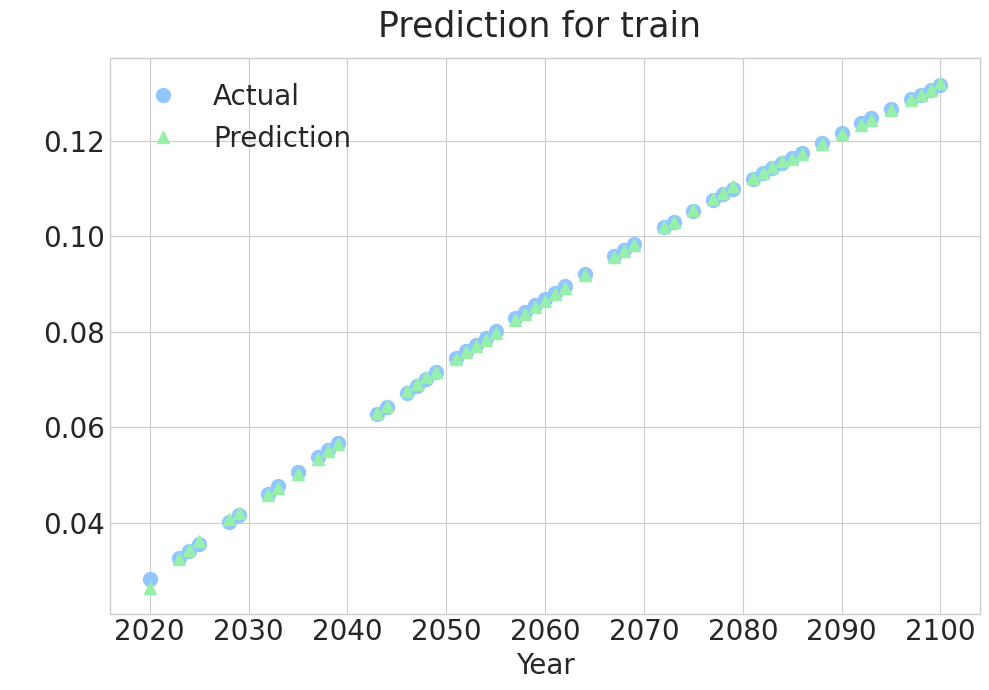

In [379]:
n= 2

plot_pred_actual(year= X_train_scld[fund_id_train][:, 1], 
                 y_actual= y_train_scld[fund_id_train][:, n],
                 y_pred= y_train_pred[fund_id_train][:, n-1],
                 title= "Prediction for train ",
                 save=True,
                 savename= svr_prtp_folder + "/" + "pred_train_scld_" + scc_col_name_ls[n]
                 )

In [380]:
len(page_data)

81

In [381]:
len(fund_data_use)

81

In [382]:
len(page_data_current)

81

In [383]:
page_id_train= np.where((y_train_scld[:, 0] >= len(fund_data_use)) & (y_train_scld[:, 0] < len(fund_data_use)*2))
page_id_val= np.where((y_val_scld[:, 0] >= len(fund_data_use)) & (y_val_scld[:, 0] < len(fund_data_use)*2))

In [384]:
# page_id_train= np.where(y_train_scld[:, 0] >= len(fund_data_use))
# page_id_val= np.where(y_val_scld[:, 0] >= len(fund_data_use))

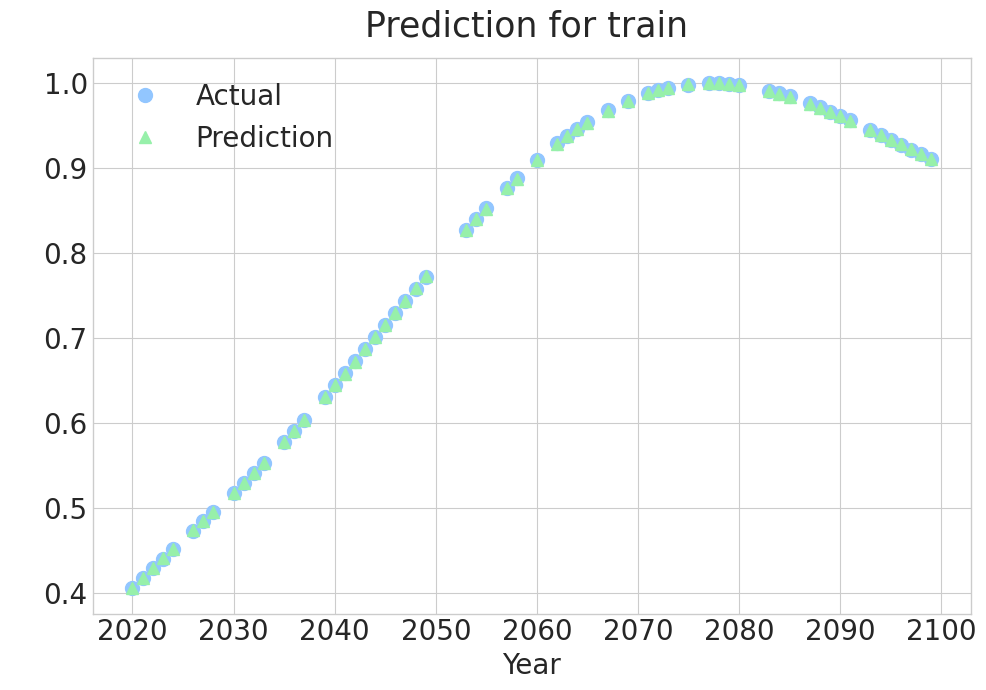

In [385]:
n= 1

plot_pred_actual(year= X_train_scld[page_id_train][:, 1], 
                 y_actual= y_train_scld[page_id_train][:, n],
                 y_pred= y_train_pred[page_id_train][:, n-1],
                 title= "Prediction for train ",
                 save=True,
                 savename= svr_prtp_folder + "/" + "pred_train_scld_" + scc_col_name_ls[n]
                 )

In [386]:
dice_id_train= np.where((y_train_scld[:, 0] >= len(fund_data_use)*2))
dice_id_val= np.where((y_val_scld[:, 0] >= len(fund_data_use)*2))

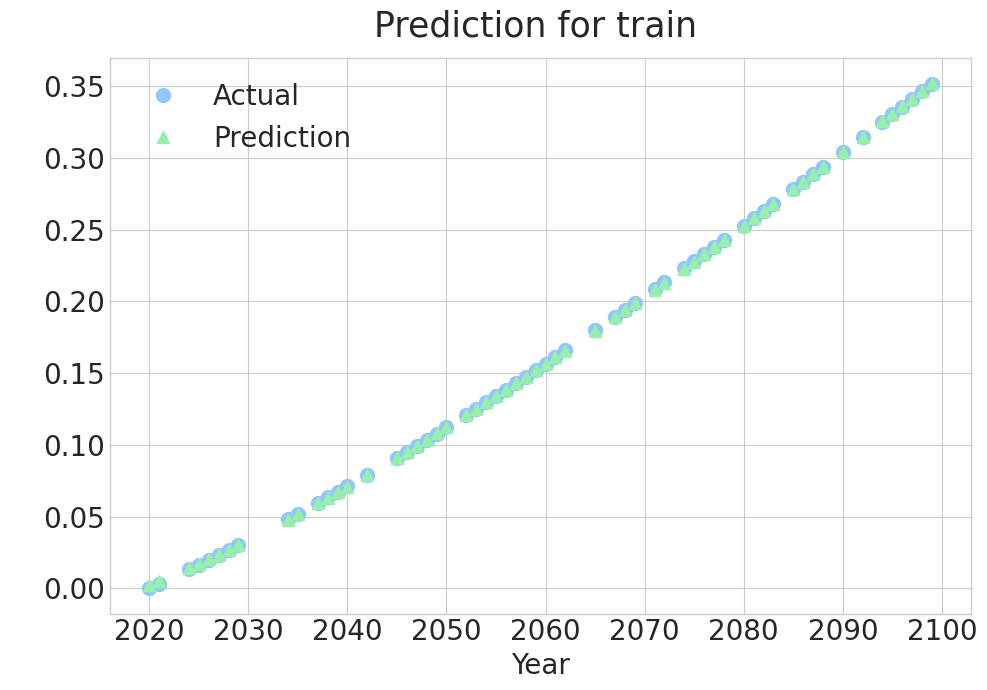

In [387]:
n= 1

plot_pred_actual(year= X_train_scld[dice_id_train][:, 1], 
                 y_actual= y_train_scld[dice_id_train][:, n],
                 y_pred= y_train_pred[dice_id_train][:, n-1],
                 title= "Prediction for train ",
                 save=True,
                 savename= svr_prtp_folder + "/" + "pred_train_scld_" + scc_col_name_ls[n]
                 )

In [388]:
y_train_inv = svr_IAM.scaling_transform(choose_scaler= scaler,
                                        for_scale= y_df_use,
                                        inverse='yes',
                                        for_inverse= y_train_scld[:, 1:])


y_val_inv = svr_IAM.scaling_transform(choose_scaler= scaler,
                                      for_scale= y_df_use,
                                      inverse='yes',
                                      for_inverse= y_val_scld[:, 1:])


y_train_pred_inv = svr_IAM.scaling_transform(choose_scaler= scaler,
                                            for_scale= y_df_use,
                                            inverse='yes',
                                            for_inverse= y_train_pred)


y_val_pred_inv = svr_IAM.scaling_transform(choose_scaler= scaler,
                                           for_scale= y_df_use,
                                           inverse='yes',
                                           for_inverse= y_val_pred)


In [389]:
np.savetxt(svr_prtp_folder + "/" + "y_train_pred_inv.txt", y_train_pred_inv)
np.savetxt(svr_prtp_folder + "/" + "y_val_pred_inv.txt", y_val_pred_inv)

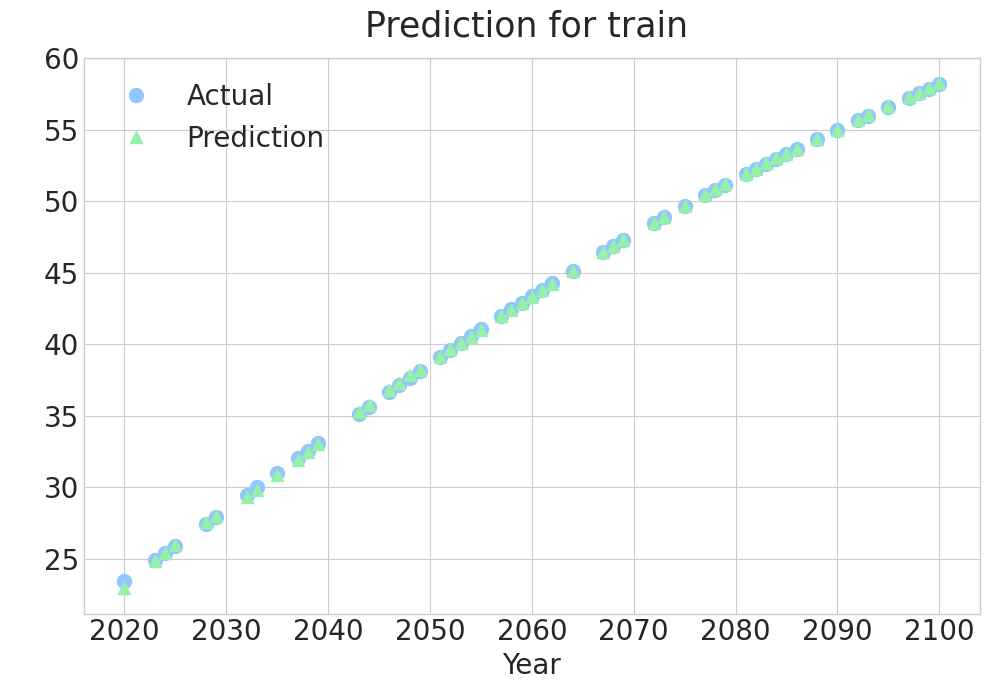

In [390]:
n= 1

plot_pred_actual(year= X_train_scld[fund_id_train][:, 1], 
                 y_actual= y_train.iloc[fund_id_train].iloc[:, n-1],
                 y_pred= y_train_pred_inv[fund_id_train][:, n-1],
                 title= "Prediction for train ",
                 save=True,
                 savename= svr_prtp_folder + "/" + "pred_train_scld_" + scc_col_name_ls[n]
                 )

### 6. Load model and prediction test data

In [391]:
import joblib

In [392]:
""" LOAD MODEL """

model= joblib.load(svr_prtp_folder + "/" + add_name + "_SVR_model.pkl")

In [393]:
y_test_pred= model.predict(X_test_scld[:, 1:])

In [394]:
y_test_inv = svr_IAM.scaling_transform(choose_scaler= scaler,
                                        for_scale= y_df_use,
                                        inverse='yes',
                                        for_inverse= y_test_scld)
                                        
y_test_pred_inv = svr_IAM.scaling_transform(choose_scaler= scaler,
                                            for_scale= y_df_use,
                                            inverse='yes',
                                            for_inverse= y_test_pred)

In [395]:
np.savetxt(svr_prtp_folder + "/" + "y_test_pred_scld.txt", y_test_pred)
np.savetxt(svr_prtp_folder + "/" + "y_test_pred_inv.txt", y_test_pred_inv)

In [396]:
""" RMSE """

test_rmse = svr_IAM.RMSE_calc(actual= y_test_scld, prediction= y_test_pred)
print(test_rmse)



""" R2 """

test_r2 = svr_IAM.r2_calc(actual= y_test_scld, prediction= y_test_pred)
print(test_r2)

# """ MAPE """

# test_mape = svr_IAM.MAPE_calc(actual= y_test_scld, prediction= y_test_pred)
# print(test_mape)

0.00044461948511774637
0.9999987796544106


In [397]:
eval_metric_df= pd.DataFrame({"Data": ["train", 'val', 'test'],
                              "RMSE": [train_rmse, val_rmse, test_rmse],
                              "R2": [train_r2, val_r2, test_r2]})

eval_metric_df

,Data,RMSE,R2
0,train,0.000378,0.999999
1,val,0.000385,0.999999
2,test,0.000445,0.999999


In [398]:
# test_rmse_r2_df= pd.DataFrame({'RMSE': [test_rmse], 'R2': [test_r2]})
# test_rmse_r2_df

In [399]:
# test_rmse_r2_df.to_csv(svr_prtp_folder + "/" + "test_rmse_r2.csv")

In [400]:
eval_metric_df.to_csv(svr_prtp_folder + "/" + "eval_metric_train_val_test.csv")

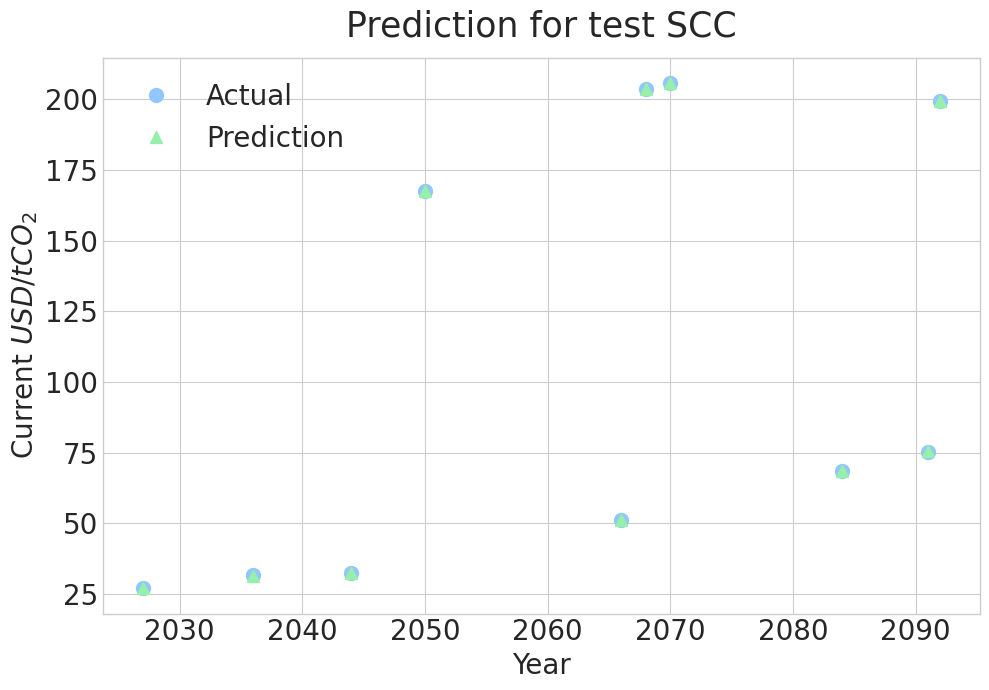

In [401]:
n=0

plot_pred_actual(year= year_test, 
                 y_actual= y_test.iloc[:, n],
                 y_pred= y_test_pred_inv[:, n],
                 y_label= "Current " + "$ USD/t CO_2$",
                 title= "Prediction for test " + scc_col_name_ls[n],
                 save=True,
                 savename= svr_prtp_folder + "/" + "pred_test_inv_" + scc_col_name_ls[n])

In [402]:
pred_inv_combine= np.vstack([y_train_pred_inv, y_val_pred_inv, y_test_pred_inv])
pred_inv_combine.shape

(243, 4)

In [403]:
index_all= np.vstack([id_train.reshape(-1,1), id_val.reshape(-1,1), id_test.reshape(-1,1)])

In [404]:
year_all= np.hstack([year_train, year_val, year_test])
year_all

array([2062., 2020., 2031., 2072., 2035., 2025., 2068., 2024., 2064.,
       2091., 2053., 2035., 2095., 2049., 2039., 2051., 2083., 2059.,
       2038., 2044., 2048., 2083., 2094., 2075., 2054., 2085., 2077.,
       2079., 2034., 2063., 2096., 2021., 2037., 2057., 2047., 2029.,
       2047., 2029., 2077., 2079., 2088., 2057., 2073., 2062., 2022.,
       2052., 2097., 2080., 2055., 2099., 2032., 2082., 2099., 2027.,
       2065., 2058., 2060., 2062., 2052., 2074., 2046., 2039., 2038.,
       2024., 2069., 2090., 2026., 2076., 2042., 2055., 2044., 2028.,
       2054., 2095., 2040., 2023., 2088., 2090., 2032., 2047., 2061.,
       2092., 2098., 2028., 2089., 2099., 2058., 2053., 2094., 2025.,
       2041., 2060., 2049., 2069., 2056., 2086., 2093., 2037., 2068.,
       2067., 2087., 2083., 2098., 2061., 2078., 2081., 2045., 2021.,
       2048., 2045., 2081., 2097., 2084., 2059., 2054., 2072., 2020.,
       2053., 2085., 2026., 2087., 2086., 2033., 2040., 2058., 2043.,
       2072., 2024.,

In [405]:
pred_inv_combine_df= pd.concat([pd.DataFrame(data= index_all, columns= ["ID"]),
                                pd.DataFrame(data= year_all, columns= ["Year"]),
                                pd.DataFrame(data= pred_inv_combine, columns= y_df_use.columns)], axis=1).sort_values(by=["ID"]).reset_index(drop=True)


In [406]:
pred_inv_combine_df

,ID,Year,SCC_9,SCC_10,SCC_11,SCC_12
0,0.0,2020.0,22.953436,27.925058,36.022496,38.468331
1,1.0,2021.0,23.752873,28.869351,37.045771,40.003386
2,2.0,2022.0,24.307021,29.488137,37.567951,40.623672
3,3.0,2023.0,24.867405,30.111949,38.129996,41.317939
4,4.0,2024.0,25.433106,30.738705,38.726229,42.073551
...,...,...,...,...,...,...
238,238.0,2096.0,80.537072,99.412015,145.929538,182.020481
239,239.0,2097.0,81.570728,100.718765,147.866378,184.371501
240,240.0,2098.0,82.607180,102.032979,149.831247,186.768503
241,241.0,2099.0,83.646389,103.354990,151.827666,189.219278


In [407]:
fund_data_pred_inv= pred_inv_combine_df.iloc[:len(fund_data_use)]
fund_data_pred_inv

,ID,Year,SCC_9,SCC_10,SCC_11,SCC_12
0,0.0,2020.0,22.953436,27.925058,36.022496,38.468331
1,1.0,2021.0,23.752873,28.869351,37.045771,40.003386
2,2.0,2022.0,24.307021,29.488137,37.567951,40.623672
3,3.0,2023.0,24.867405,30.111949,38.129996,41.317939
4,4.0,2024.0,25.433106,30.738705,38.726229,42.073551
...,...,...,...,...,...,...
76,76.0,2096.0,56.969710,63.510385,72.918119,76.277827
77,77.0,2097.0,57.280012,63.879640,73.324400,76.570540
78,78.0,2098.0,57.588878,64.252019,73.733905,76.858205
79,79.0,2099.0,57.896671,64.628042,74.146902,77.141519


### Plotting

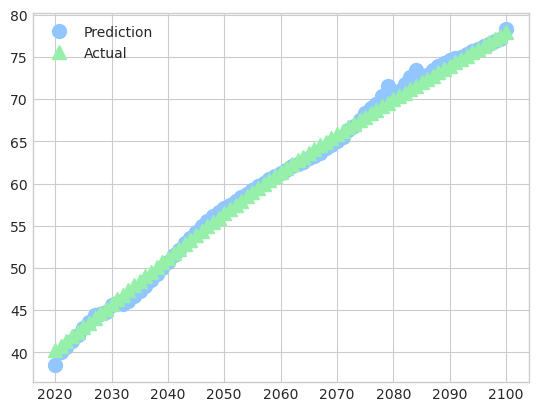

In [409]:
col_use= 'SCC_12'
plt.plot(fund_data_pred_inv['Year'], fund_data_pred_inv[col_use], 
         marker="o", markersize=10, linestyle="None", label= "Prediction")

plt.plot(fund_data_pred_inv['Year'], FUND_y_df[col_use], 
         marker="^" , markersize=10, linestyle="None", label= "Actual")

plt.legend()

In [410]:
fund_data_pred_inv.to_csv(svr_prtp_folder + "/" + "fund_data_pred_inv_all.csv")

In [411]:
page_data_pred_inv= pred_inv_combine_df.iloc[len(fund_data_use):len(fund_data_use)*2]
page_data_pred_inv, page_data_pred_inv.shape

(        ID    Year       SCC_9      SCC_10       SCC_11       SCC_12
 81    81.0  2020.0   94.023389  156.695614   452.078522  1096.050342
 82    82.0  2021.0   96.339963  160.951068   465.848637  1121.874413
 83    83.0  2022.0   98.576175  165.074896   479.202847  1146.578262
 84    84.0  2023.0  100.765863  169.121890   492.284370  1170.512851
 85    85.0  2024.0  102.908868  173.091971   505.093574  1193.703650
 ..     ...     ...         ...         ...          ...          ...
 157  157.0  2096.0  194.885730  345.777587  1032.501673  2019.379945
 158  158.0  2097.0  193.767510  343.802421  1026.355764  1998.077431
 159  159.0  2098.0  192.658216  341.832380  1020.177580  1976.710457
 160  160.0  2099.0  191.569780  339.884982  1014.009597  1955.393109
 161  161.0  2100.0  190.526064  337.997892  1007.953336  1934.367456
 
 [81 rows x 6 columns],
 (81, 6))

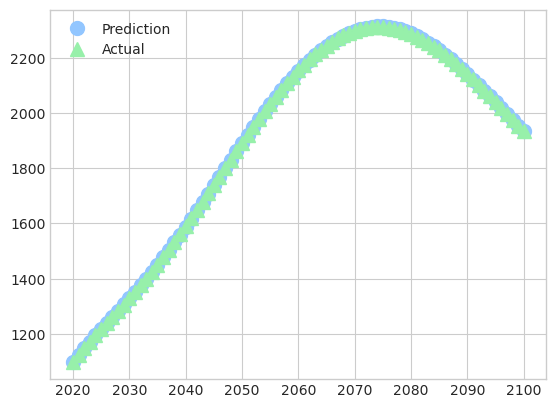

In [412]:
col_use= 'SCC_12'
plt.plot(page_data_pred_inv['Year'], page_data_pred_inv[col_use], 
         marker="o", markersize=10, linestyle="None", label= "Prediction")

plt.plot(page_data_pred_inv['Year'], PAGE_y_df[col_use], 
         marker="^" , markersize=10, linestyle="None", label= "Actual")

plt.legend()

In [413]:
page_data_pred_inv

,ID,Year,SCC_9,SCC_10,SCC_11,SCC_12
81,81.0,2020.0,94.023389,156.695614,452.078522,1096.050342
82,82.0,2021.0,96.339963,160.951068,465.848637,1121.874413
83,83.0,2022.0,98.576175,165.074896,479.202847,1146.578262
84,84.0,2023.0,100.765863,169.121890,492.284370,1170.512851
85,85.0,2024.0,102.908868,173.091971,505.093574,1193.703650
...,...,...,...,...,...,...
157,157.0,2096.0,194.885730,345.777587,1032.501673,2019.379945
158,158.0,2097.0,193.767510,343.802421,1026.355764,1998.077431
159,159.0,2098.0,192.658216,341.832380,1020.177580,1976.710457
160,160.0,2099.0,191.569780,339.884982,1014.009597,1955.393109


In [414]:
page_data_pred_inv.to_csv(svr_prtp_folder + "/" + "page_data_pred_inv_all.csv")

In [415]:
dice_data_pred_inv= pred_inv_combine_df.iloc[len(fund_data_use)*2:len(fund_data_use)*3]
dice_data_pred_inv, dice_data_pred_inv.shape

(        ID    Year      SCC_9      SCC_10      SCC_11      SCC_12
 162  162.0  2020.0  16.035481   19.001713   25.658524   31.315486
 163  163.0  2021.0  16.579752   19.699233   26.791318   32.746866
 164  164.0  2022.0  17.134253   20.406633   27.932977   34.160121
 165  165.0  2023.0  17.700736   21.126523   29.086147   35.566392
 166  166.0  2024.0  18.280493   21.860977   30.253348   36.975850
 ..     ...     ...        ...         ...         ...         ...
 238  238.0  2096.0  80.537072   99.412015  145.929538  182.020481
 239  239.0  2097.0  81.570728  100.718765  147.866378  184.371501
 240  240.0  2098.0  82.607180  102.032979  149.831247  186.768503
 241  241.0  2099.0  83.646389  103.354990  151.827666  189.219278
 242  242.0  2100.0  84.688362  104.685211  153.859469  191.732316
 
 [81 rows x 6 columns],
 (81, 6))

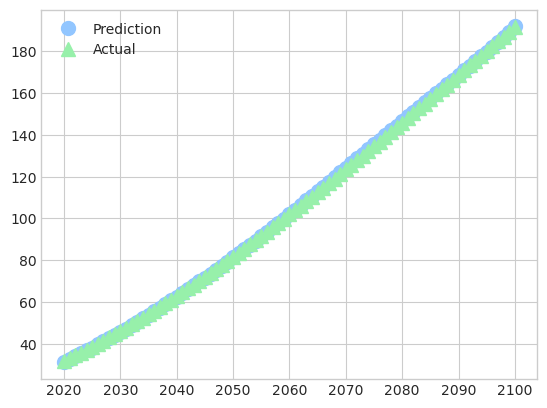

In [416]:
col_use= 'SCC_12'
plt.plot(dice_data_pred_inv['Year'], dice_data_pred_inv[col_use], 
         marker="o", markersize=10, linestyle="None", label= "Prediction")

plt.plot(dice_data_pred_inv['Year'], DICE_y_df[col_use], 
         marker="^" , markersize=10, linestyle="None", label= "Actual")

plt.legend()

In [417]:
def plot_compare_final(col_use, pred_inv_data, actual_y_data, 
                       title, y_label= " ", ymin=None, ymax=None, 
                       legend_loc= "upper left",
                       save=False, savename=None, ncol=1, s=10,
                       L=7, H=5, fs=20, pad=7):
    
    plt.figure(figsize=(L,H))
    plt.plot(pred_inv_data['Year'], actual_y_data[col_use], 
             marker="^" , markersize=10, linestyle="None", label= "Actual", color= "lightgreen")
    plt.plot(pred_inv_data['Year'], pred_inv_data[col_use], 
             marker="o", markersize=10, linestyle="None", label= "Prediction", color= "lightblue")


    plt.title(title, fontsize=fs, pad=pad)

    plt.xlabel("Year", fontsize= fs-5)
    plt.ylabel(y_label, fontsize= fs-5)
    plt.ylim(ymin, ymax)
    plt.tick_params("both", labelsize=fs-5)

    plt.legend(fontsize= fs-5, ncol=ncol, loc=legend_loc)
    plt.tight_layout()

    if save == True:
        plt.savefig(savename + ".png", bbox_inches="tight", dpi=600)

    plt.show()


In [418]:
def plot_compare_final_2(col_use_list, pred_inv_data, actual_y_data, 
                       title, marker_list, 
                       y_label= " ", ymin=None, ymax=None, 
                       legend_loc= "upper left", bbox_loc= (1.1,1),
                       save=False, savename=None, ncol=1,
                       L=7, H=5, fs=20, pad=7):
    
    plt.figure(figsize=(L,H))

    for i in range(len(col_use_list)):
        plt.plot(pred_inv_data['Year'], actual_y_data[col_use_list[i]], 
                 marker=marker_list[i] , markersize=10, color= "lightgreen",
                 linestyle="None", label= "Actual:" + col_use_list[i])
                
        plt.plot(pred_inv_data['Year'], pred_inv_data[col_use_list[i]], 
                 marker=marker_list[i], markersize=10, color= "lightblue",
                 linestyle="None", label= "Prediction: " + col_use_list[i])

        


    plt.title(title, fontsize=fs, pad=pad)

    plt.xlabel("Year", fontsize= fs-5)
    plt.ylabel(y_label, fontsize= fs-5)
    plt.ylim(ymin, ymax)
    plt.tick_params("both", labelsize=fs-5)

    plt.legend(fontsize= fs-7, ncol=ncol, loc=legend_loc, bbox_to_anchor=bbox_loc)
    plt.tight_layout()

    if save == True:
        plt.savefig(savename + ".png", bbox_inches="tight", dpi=600)

    plt.show()


In [419]:
col_use_list= page_data_pred_inv.columns[-4:]
col_use_list

marker_list= ["o", "v", "s", "X"]

# plt.rcParams["font.family"] = "Arial Unicode MS"
plt.rcParams["font.family"] = "DejaVu Sans"

y_label= "USD2022/tCO" + "\u2082"
y_label

'USD2022/tCO₂'

In [420]:
svr_prtp_folder

'SVR_01_1030_prtp_3'

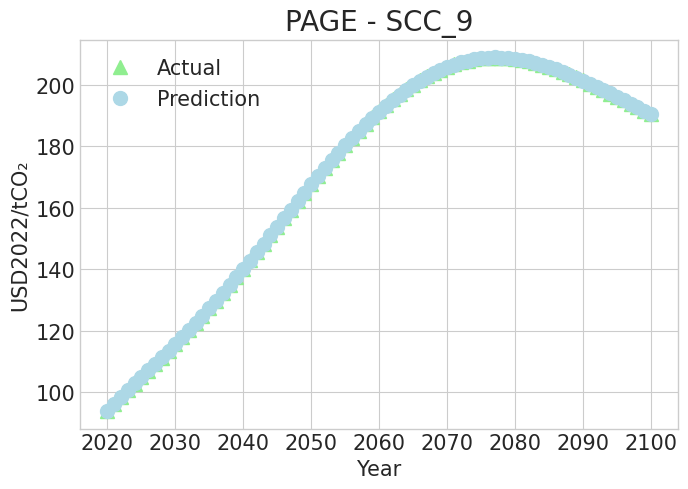

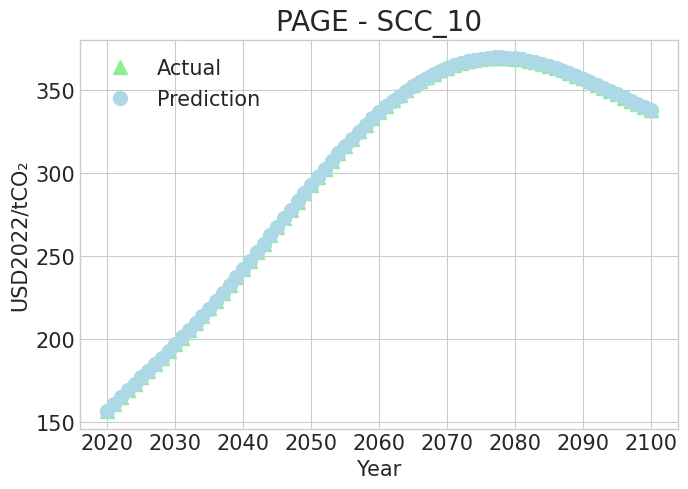

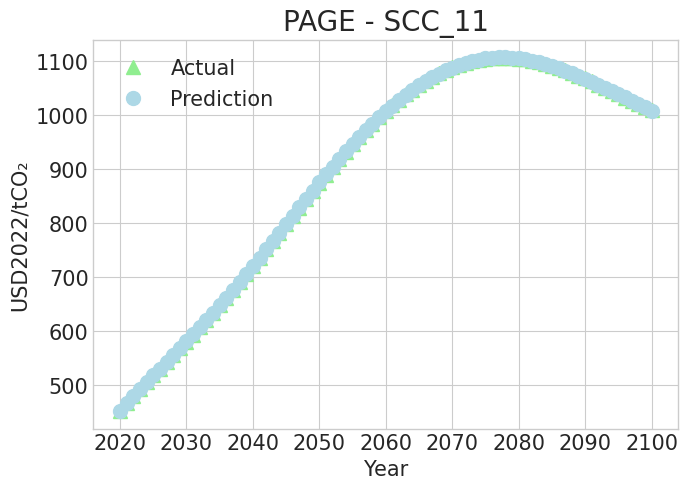

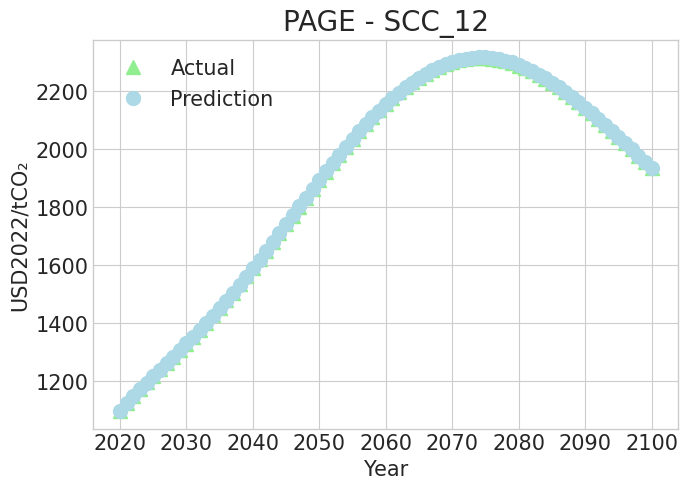

In [421]:
for col_use in col_use_list:
    plot_compare_final(col_use= col_use, 
                       pred_inv_data= page_data_pred_inv, 
                       actual_y_data= PAGE_y_df, 
                       title= "PAGE - " + col_use, 
                       y_label= y_label, 
                       ymin=None, ymax=None, 
                       legend_loc= "upper left",
                       save=True, 
                       savename= svr_prtp_folder + "/" + "pred_actual_PAGE_" + prtp_name + "_" + col_use)

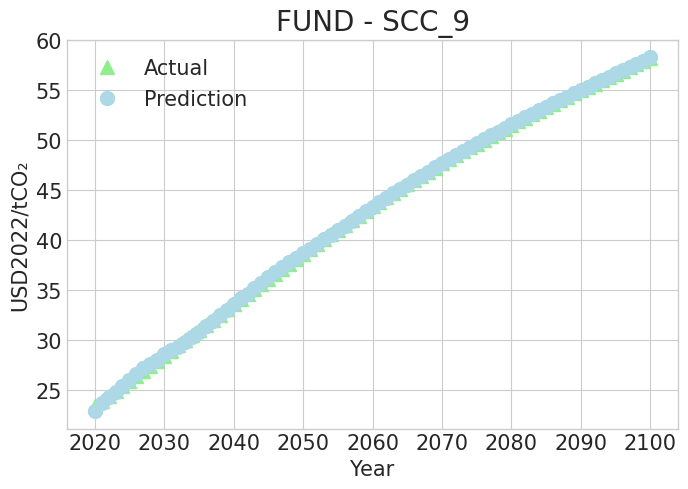

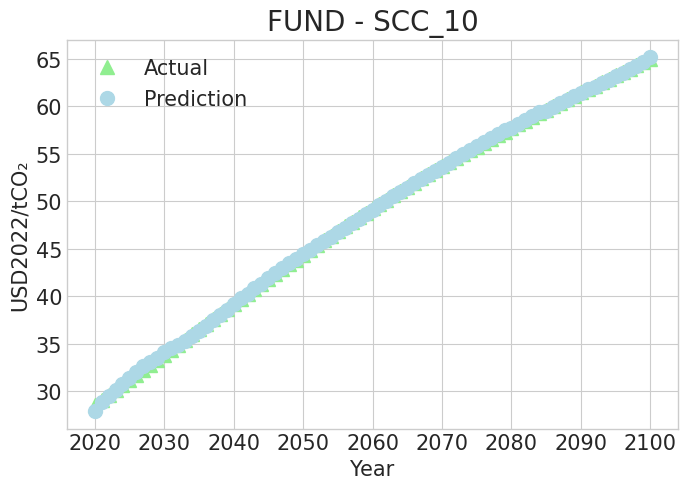

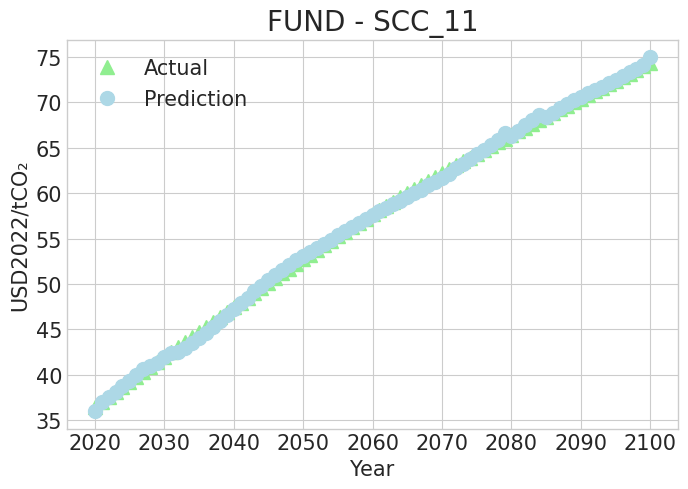

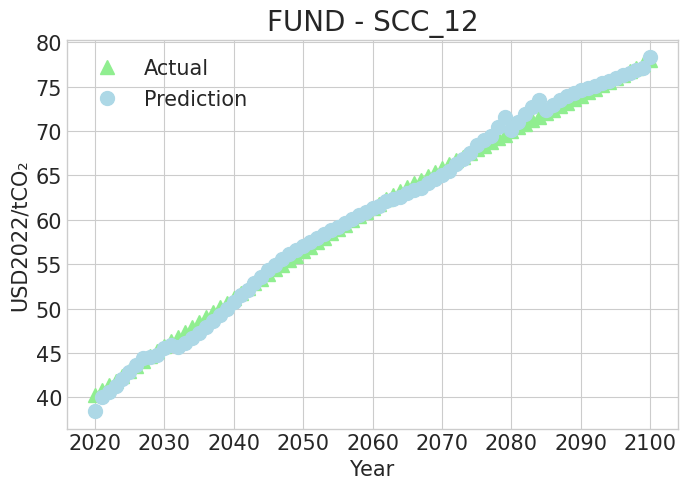

In [422]:
for col_use in col_use_list:
    plot_compare_final(col_use= col_use, 
                       pred_inv_data= fund_data_pred_inv, 
                       actual_y_data= FUND_y_df, 
                       title= "FUND - " + col_use, 
                       y_label= y_label, 
                       ymin=None, ymax=None, 
                       legend_loc= "upper left",
                       save=True, 
                       savename= svr_prtp_folder + "/" + "pred_actual_FUND_" + prtp_name + "_" + col_use)

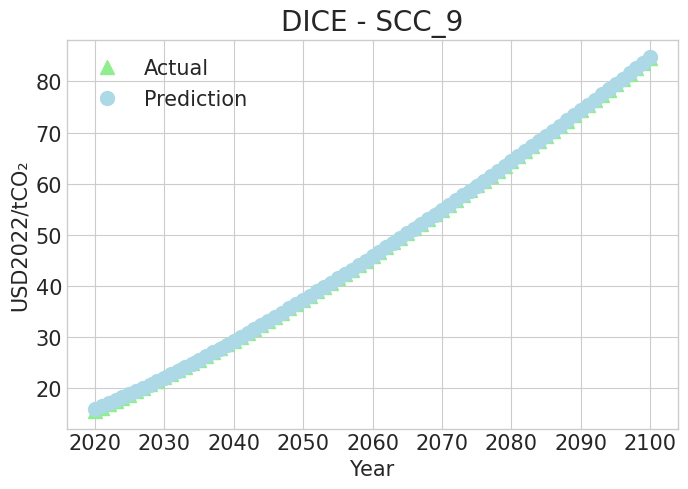

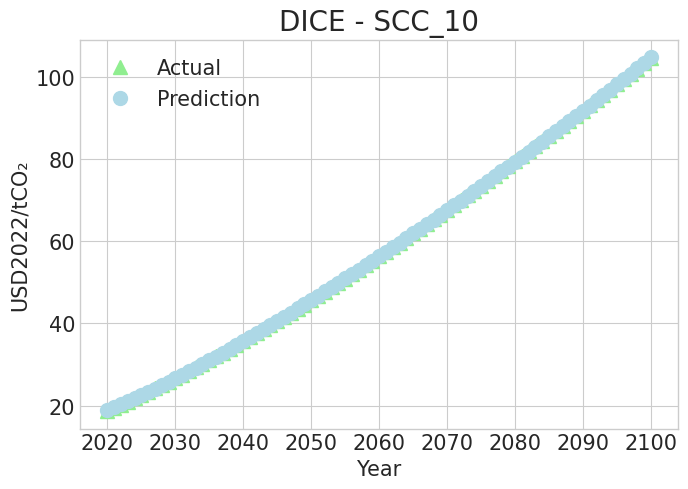

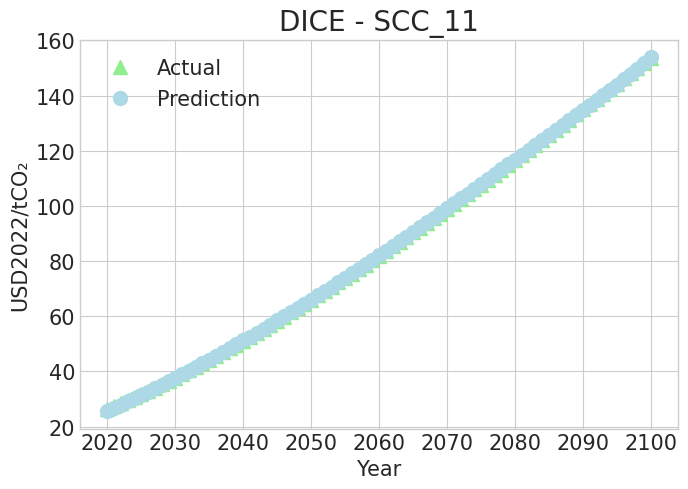

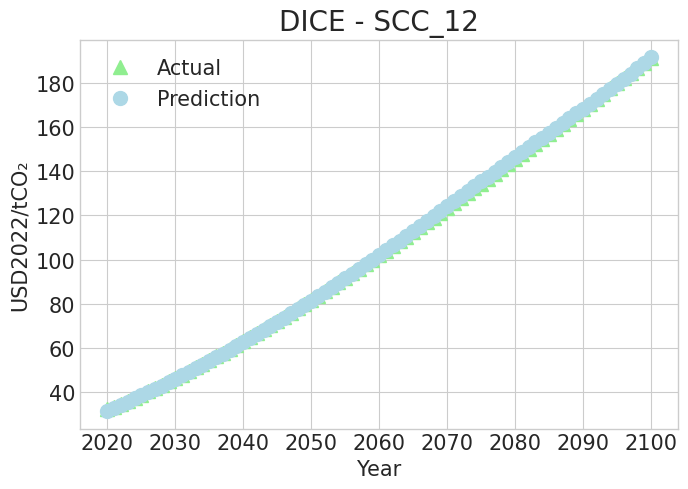

In [423]:
for col_use in col_use_list:
    plot_compare_final(col_use= col_use, 
                       pred_inv_data= dice_data_pred_inv, 
                       actual_y_data= DICE_y_df, 
                       title= "DICE - " + col_use, 
                       y_label= y_label, 
                       ymin=None, ymax=None, 
                       legend_loc= "upper left",
                       save=True, 
                       savename= svr_prtp_folder + "/" + "pred_actual_DICE_" + prtp_name + "_" + col_use)

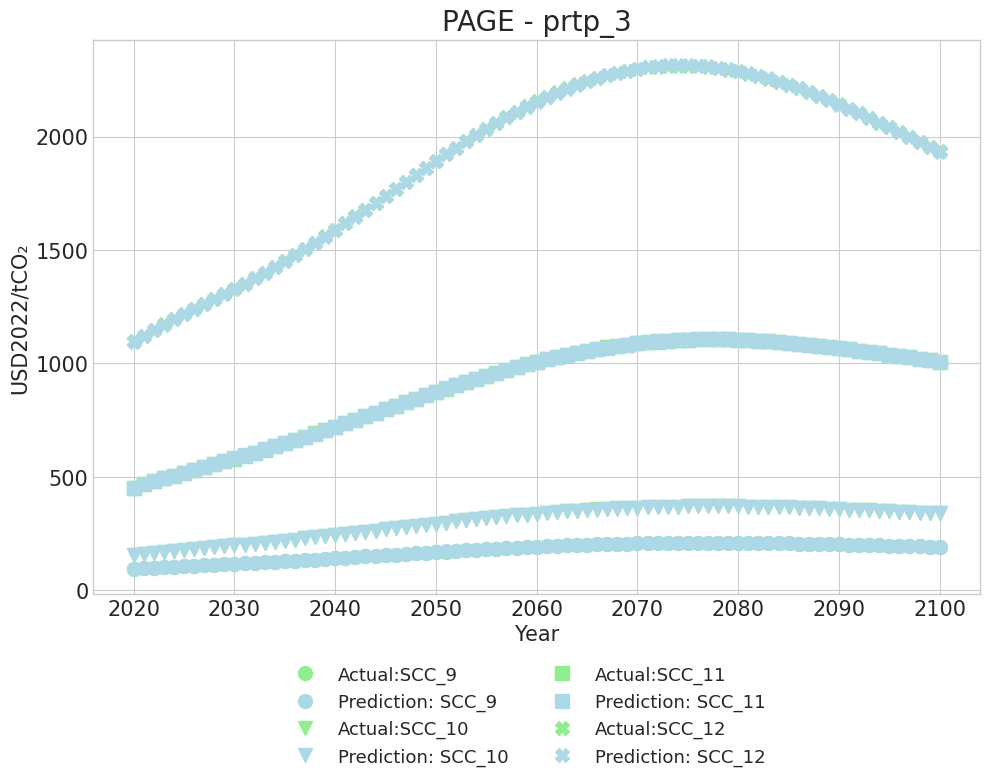

In [424]:
plot_compare_final_2(col_use_list= col_use_list, 
                    pred_inv_data= page_data_pred_inv, 
                    actual_y_data= PAGE_y_df, 
                    title= "PAGE - " + prtp_name, 
                    marker_list= marker_list,
                    y_label= y_label, 
                    bbox_loc= (0.2, -0.1),
                    ncol=2,
                    L= 10, H= 8,
                    ymin=None, ymax=None, 
                    legend_loc= "upper left",
                    save=True, 
                    savename=svr_prtp_folder + "/" + "pred_actual_PAGE_" + prtp_name + "_all")

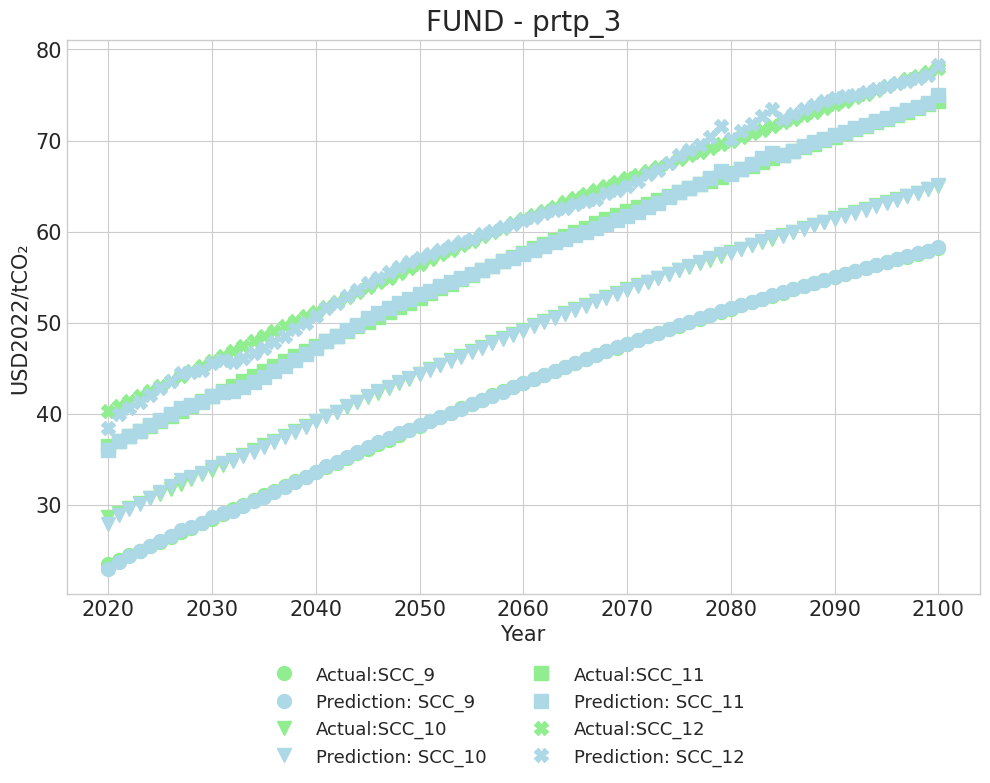

In [425]:
plot_compare_final_2(col_use_list= col_use_list, 
                    pred_inv_data= fund_data_pred_inv, 
                    actual_y_data= FUND_y_df, 
                    title= "FUND - " + prtp_name, 
                    marker_list= marker_list,
                    y_label= y_label, 
                    bbox_loc= (0.2, -0.1),
                    ncol=2,
                    L= 10, H= 8,
                    ymin=None, ymax=None, 
                    legend_loc= "upper left",
                    save=True, 
                    savename=svr_prtp_folder + "/" + "pred_actual_FUND_" + prtp_name + "_all")

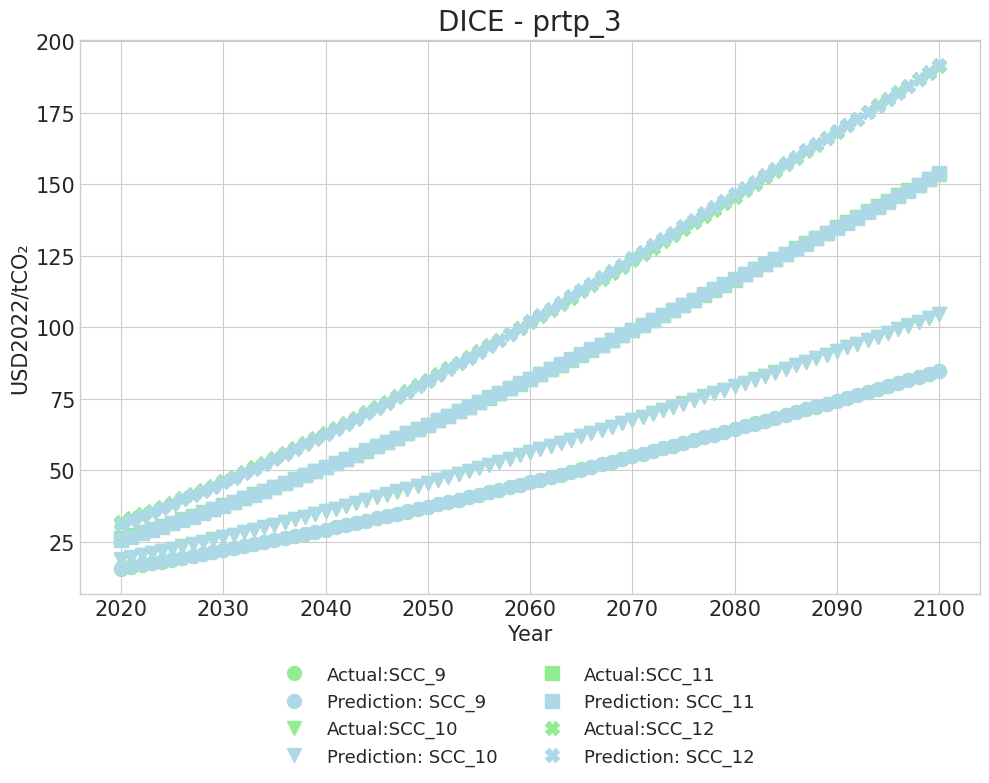

In [426]:
plot_compare_final_2(col_use_list= col_use_list, 
                    pred_inv_data= dice_data_pred_inv, 
                    actual_y_data= DICE_y_df, 
                    title= "DICE - " + prtp_name, 
                    marker_list= marker_list,
                    y_label= y_label, 
                    bbox_loc= (0.2, -0.1),
                    ncol=2,
                    L= 10, H= 8,
                    ymin=None, ymax=None, 
                    legend_loc= "upper left",
                    save=True, 
                    savename=svr_prtp_folder + "/" + "pred_actual_DCIE_" + prtp_name + "_all")